# AutoRegressive Integrated Moving Average (ARIMA)

This note illustrates how to do ARIMA in python. I will follow several tutorials for [ARIMA](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/), and and [SARIMAX](https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima).

The topics includes:
1. Checking stationarity of time seires
1. Make a time series stationary
1. Forecasting a time series

Other resources:
* There's another nice example on [Kaggle](https://www.kaggle.com/poiupoiu/how-to-use-sarimax).

* The analysis could also be done in R. There's an introductory article from [this post](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/). In addition, there are some R scripts: [Autoregressive.R](https://github.com/YuZhangIsCoding/StatsBasics/blob/master/TimeSeriesAnalysis/examples/Autoregressive.R) and [BOX-Jenkins_Seasonal.R](https://github.com/YuZhangIsCoding/StatsBasics/blob/master/TimeSeriesAnalysis/examples/BOX-Jenkins_Seasonal.R)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

%matplotlib inline
pd.options.display.max_rows = 20

In [2]:
plt.rcParams['figure.figsize'] = 8, 3
plt.rcParams['figure.dpi'] = 300

## Loading time series in Pandas

AirPassenger.csv is a replica of an inbuilt data set of R. The dataset consists of monthly totals of international airline passengers, 1949 to 1960

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month'], index_col='Month',
                  date_parser=dateparse)

In [4]:
data.head()

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

In [5]:
data.describe()

#Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000

Some examples to slice data

In [6]:
ts = data['#Passengers']
ts['1949-01-01']
ts[datetime(1949,1,1)]
ts[:'1949-05-01']
ts['1949'];

## Check Stationarity

* Constant mean
* Constant variance
* Autocovariance does not depend on time

Run-sequence plot

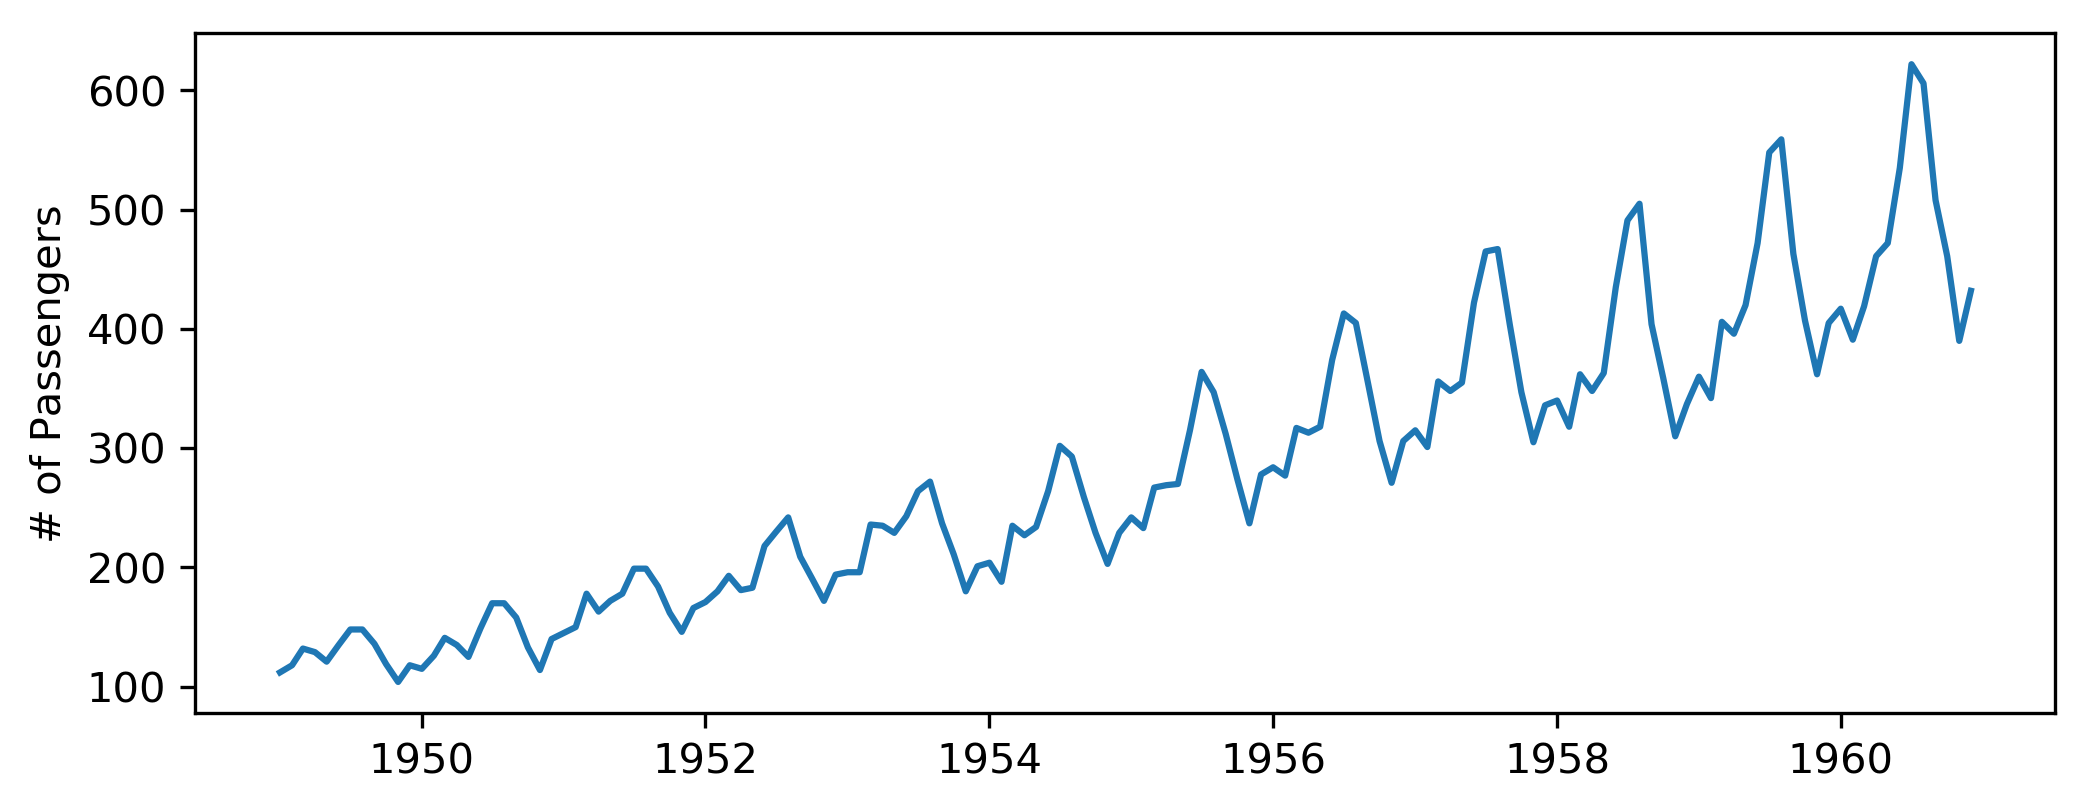

In [7]:
plt.plot(ts)
plt.ylabel('# of Passengers');

There is an **overall increasing trend**, and some seasonal variations. In addition to visual examination, we can check stationary using:

1. Plotting Rolling Statistics.
1. Dickey-Fuller Test

### Rolling statistics

In [8]:
def rolling_stats(ts):
    rollmean = ts.rolling(window=12).mean()
    rollstd = ts.rolling(window=12).std()
    plt.plot(ts, color = 'lightskyblue', label='original')
    plt.plot(rollmean, color='lightcoral', label='Rolling Mean')
    plt.plot(rollstd, color='k', label='Rolling Std')
    plt.legend();

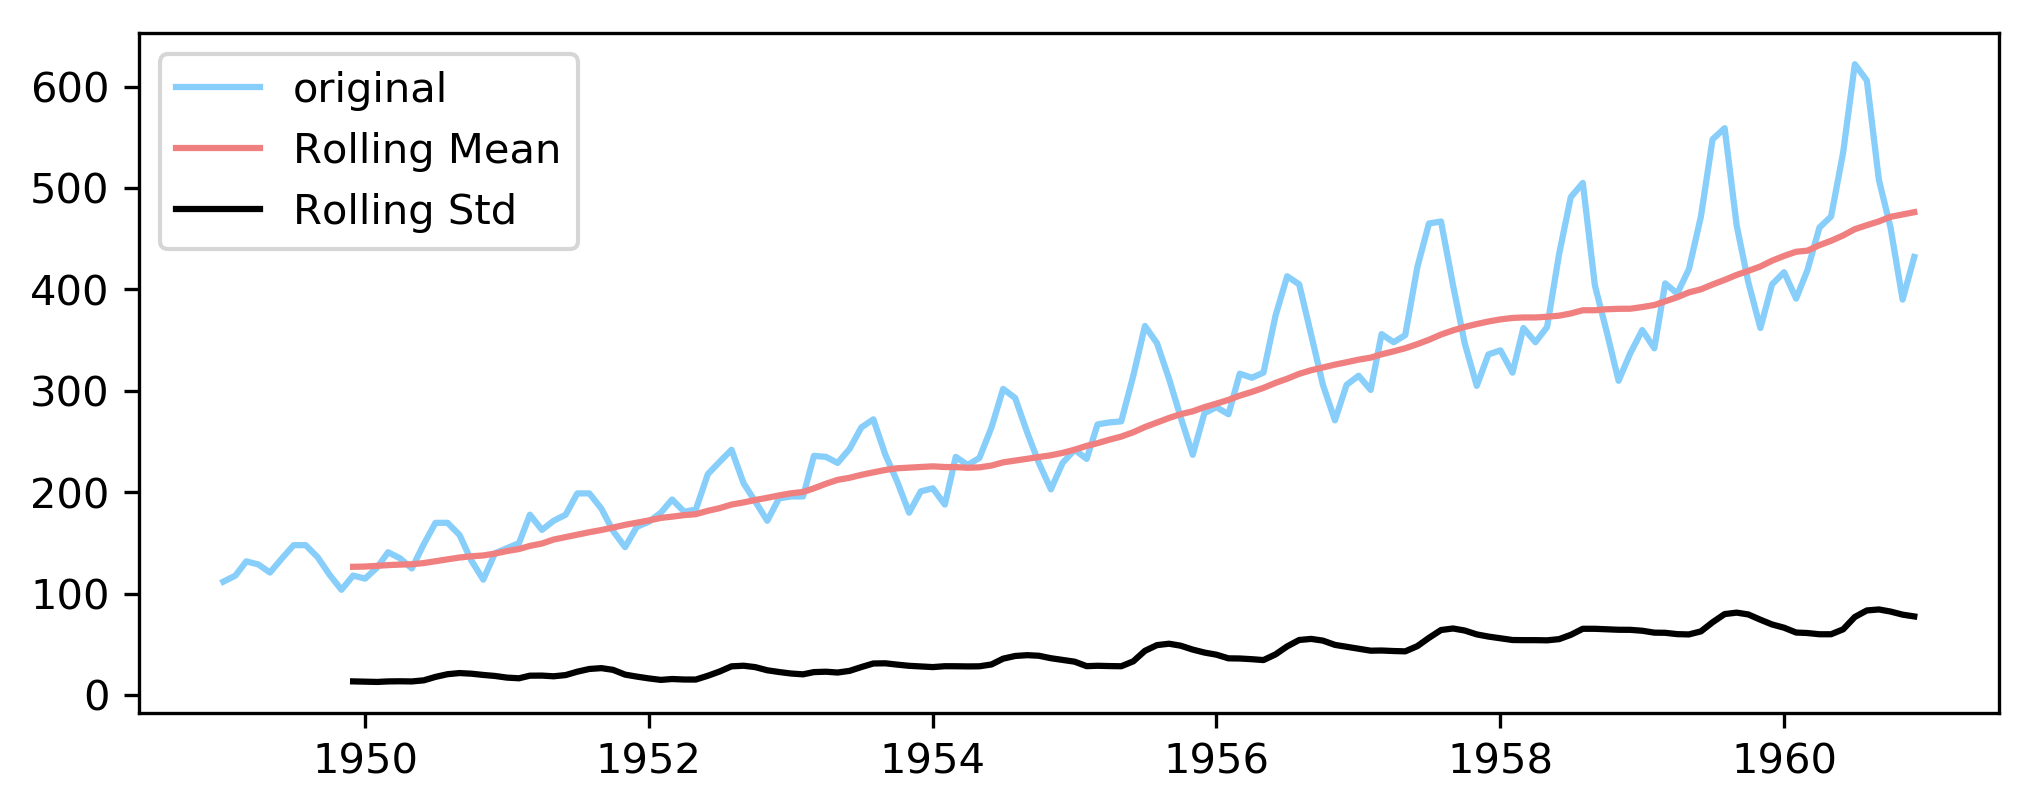

In [9]:
rolling_stats(ts)

### Dickey-Fuller test

In [10]:
def dickeyfuller(ts):
    temp = adfuller(ts, autolag='AIC')

    dfresults = pd.Series(temp[0:4], index=['Test Statistic','p-value',
                                     '#Lags Used', 'Number of Observations Used'])
    for key, value in temp[4].items():
        dfresults['Critical Value (%s)' %key] = value
    return dfresults

In [11]:
dickeyfuller(ts)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

The p-value shows that the data is not stationary!

## Making a time series stationary

1. Remove a trend
1. Remove seasonality

### Estimating & Eliminating Trend

#### Transformation to reduce the trend

Common ones including log, sqaure root, cube root, etc. We will do a log transformation here.

There are other ways, including:

1. Aggregation: taking average for a time period
1. Smoothing: taking rolling averages
1. Polynomial Fitting: fit a regression model

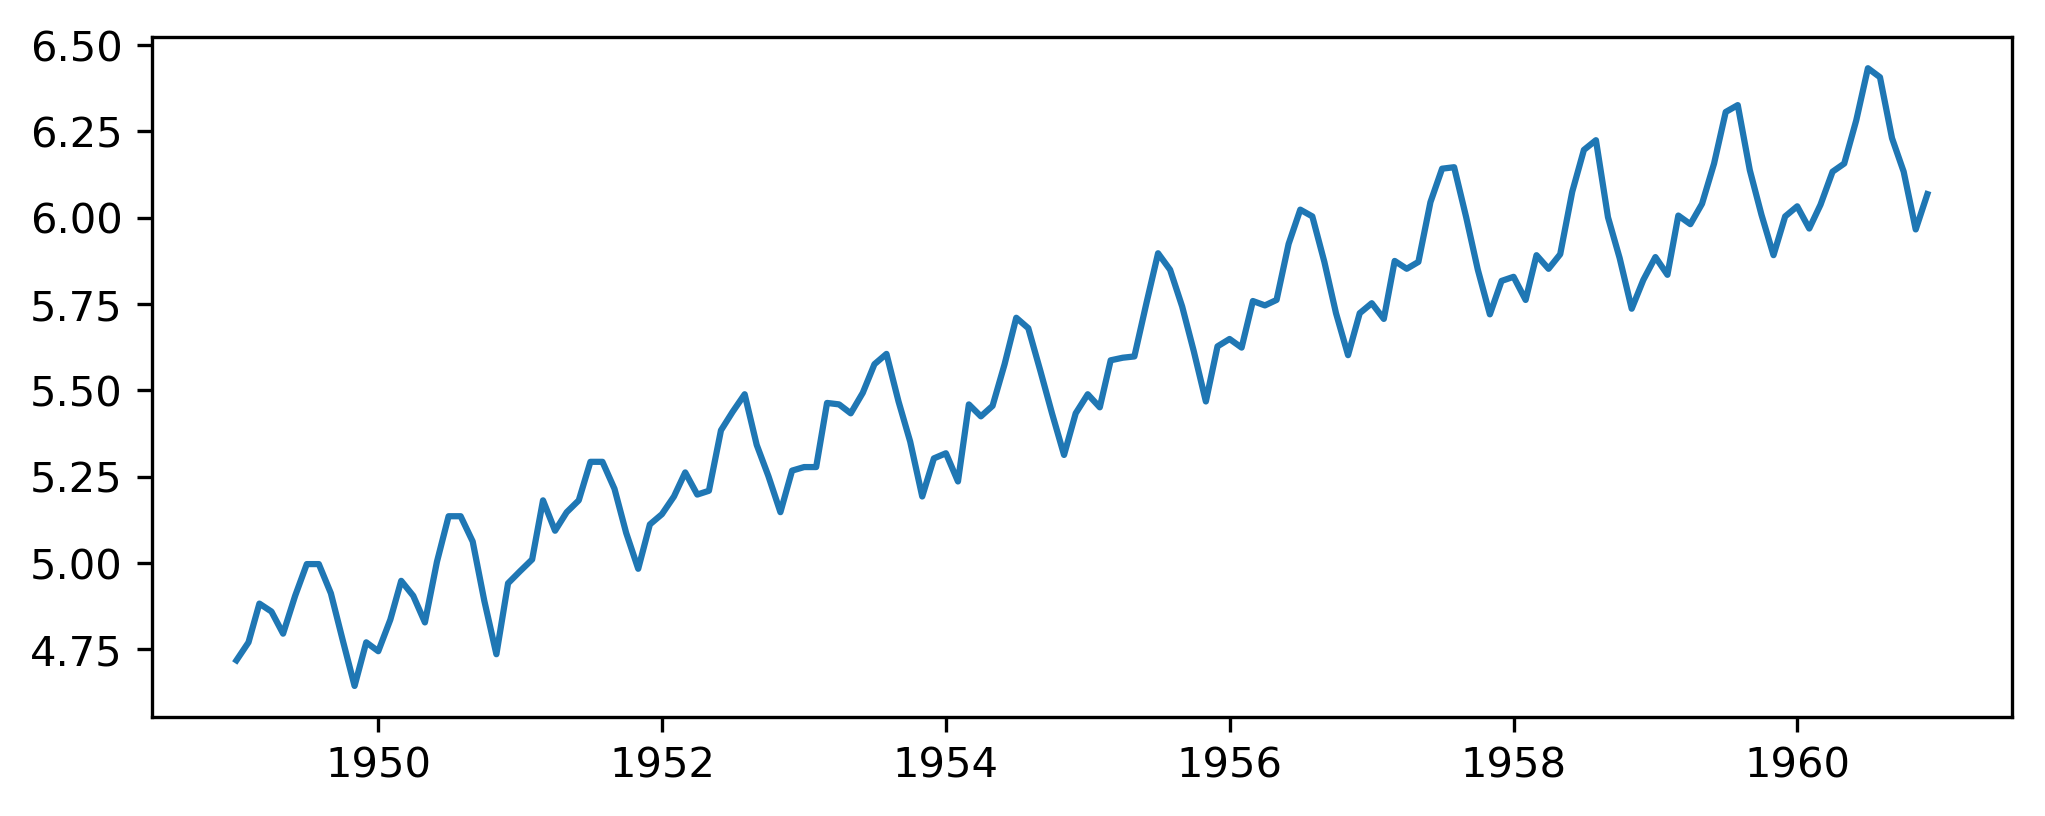

In [12]:
ts_log = np.log(ts)
plt.plot(ts_log);

#### Moving average

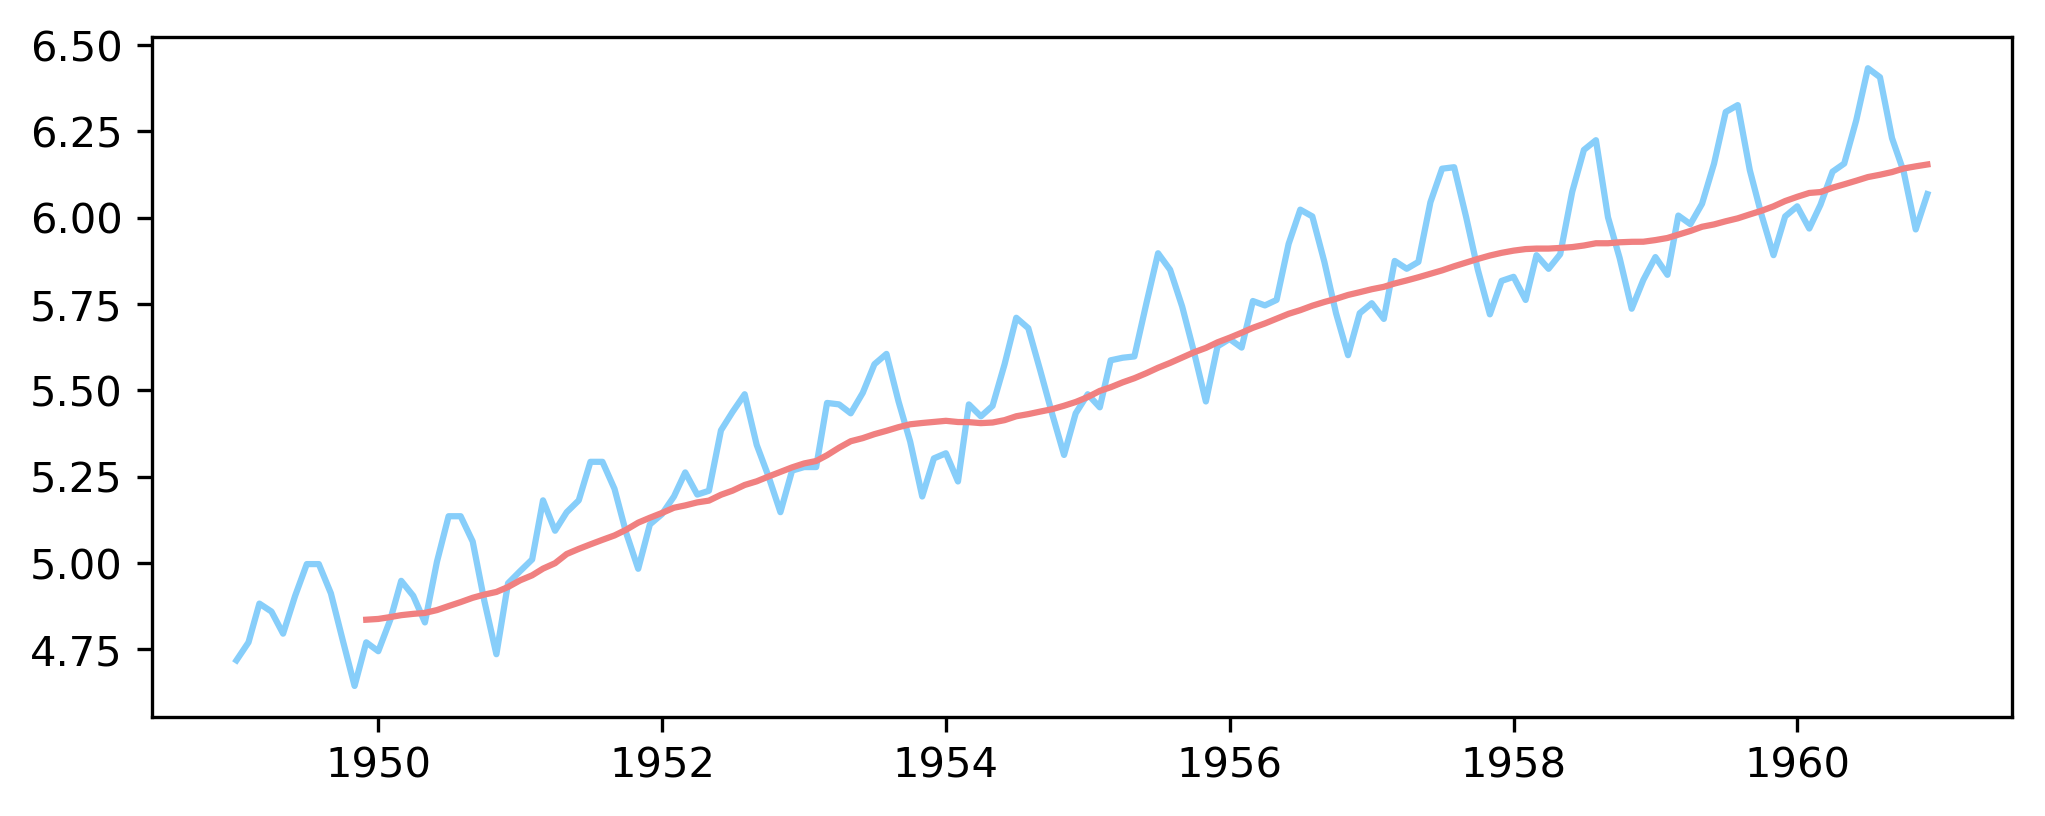

In [13]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log, color = 'lightskyblue')
plt.plot(moving_avg, color = 'lightcoral');

In [14]:
ts_log_moving_avg_diff = (ts_log-moving_avg).dropna()

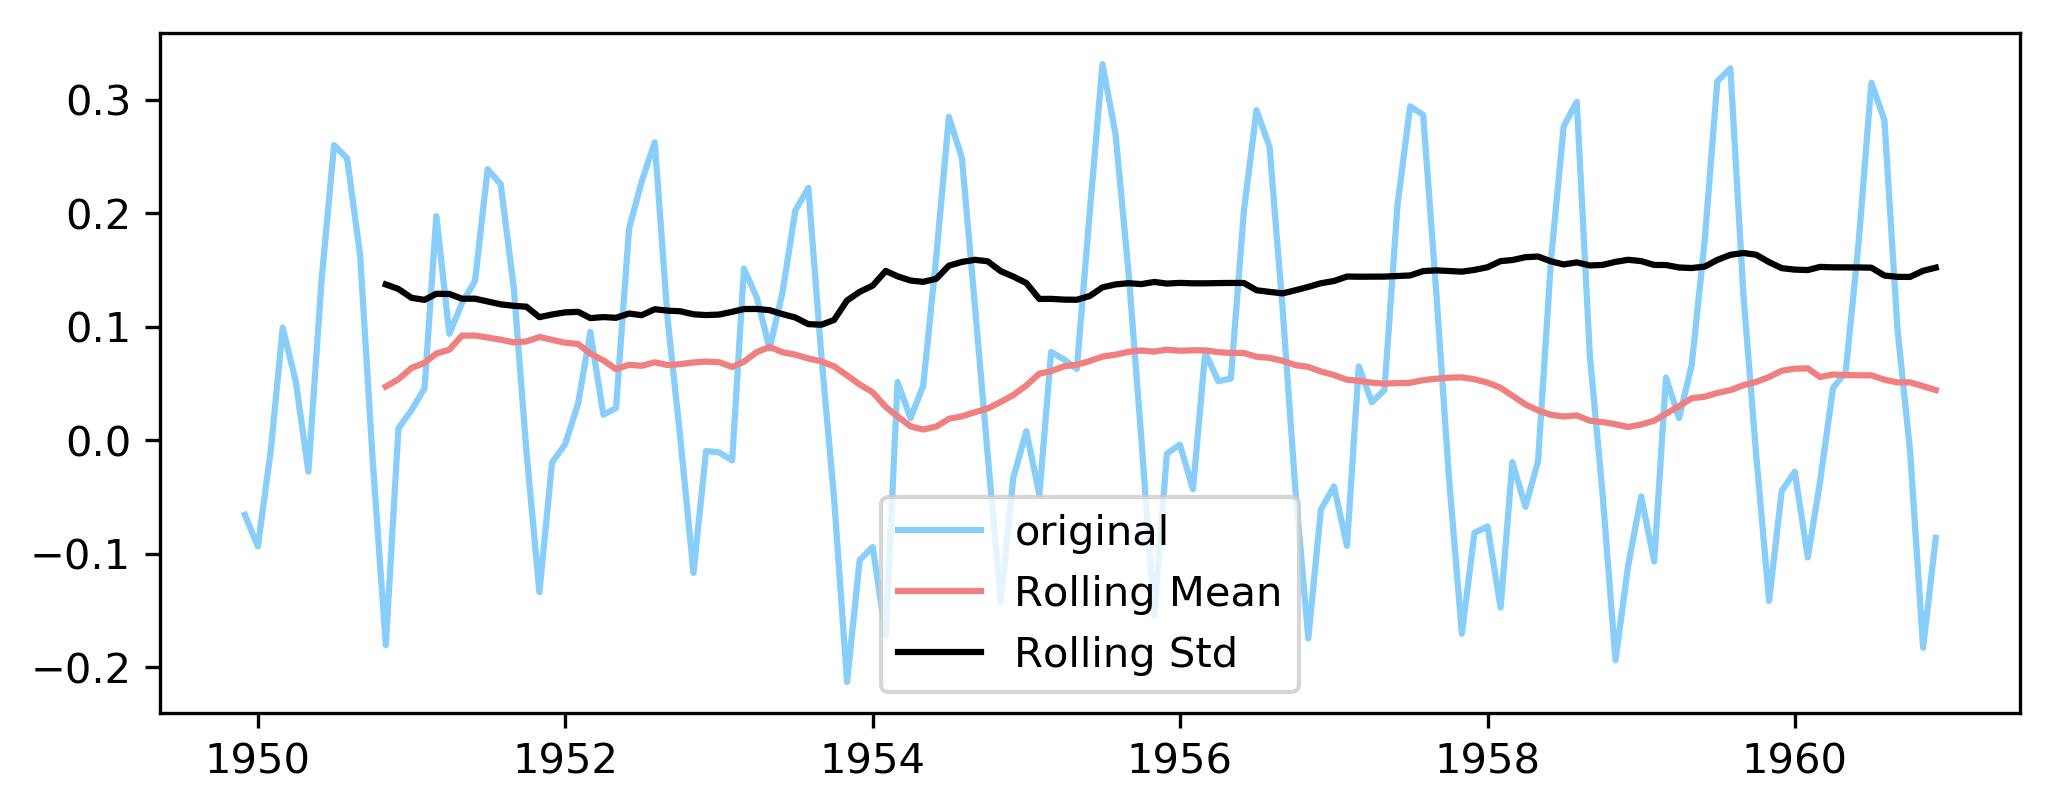

In [15]:
rolling_stats(ts_log_moving_avg_diff)

In [16]:
dickeyfuller(ts_log_moving_avg_diff)

Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64

Now the p-value is smaller than 0.05, indicating we have 95% confidence that the series is stationary.

#### Exponentially weighted moving average

When the time-period (rolling window) is not clear, weighted moving average can be useful.

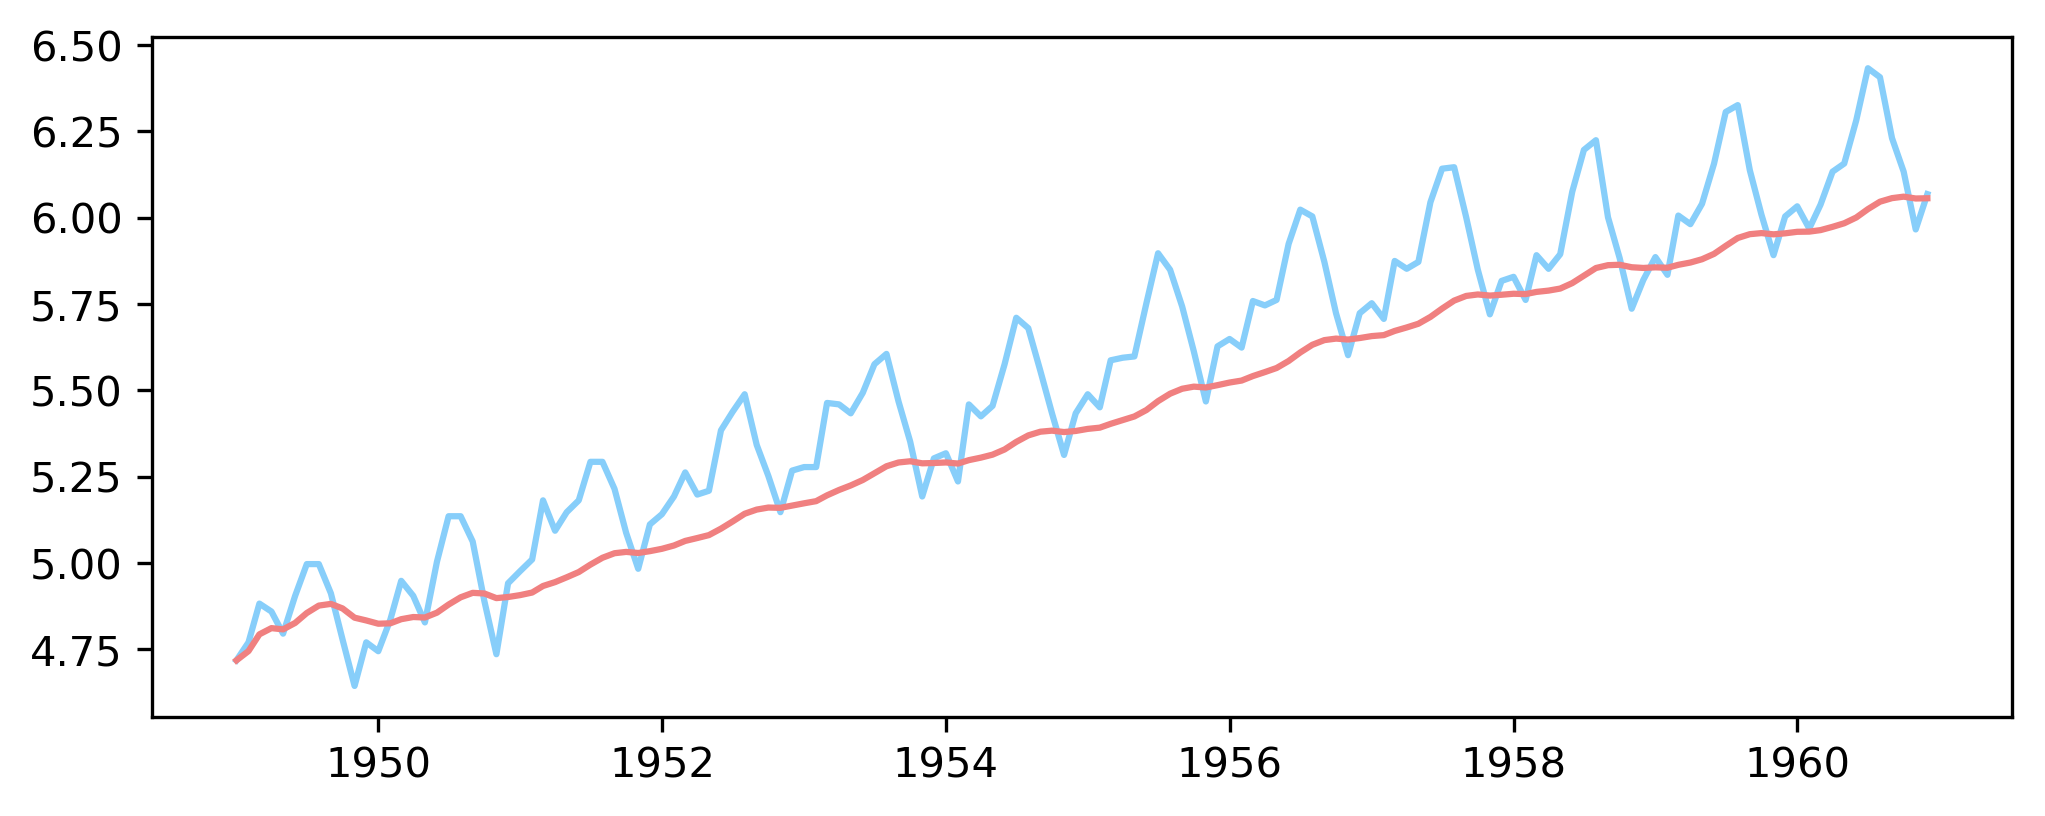

In [17]:
ewma = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log, c='lightskyblue')
plt.plot(ewma, c='lightcoral');

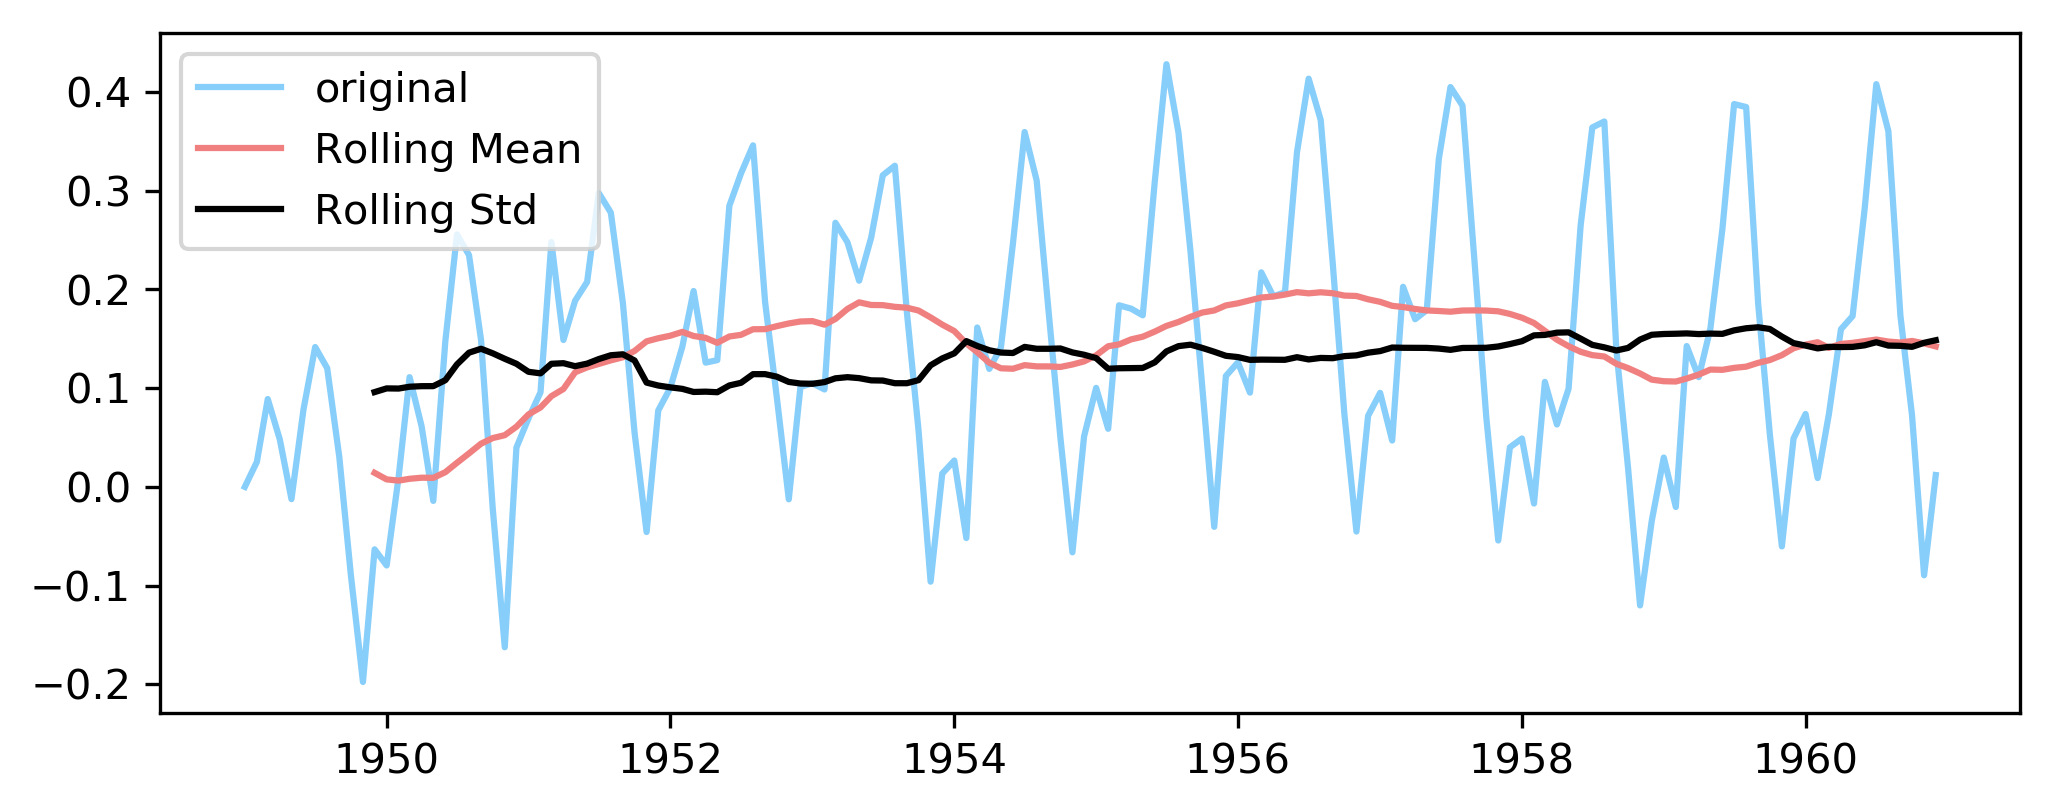

In [18]:
ts_log_ewma_diff = ts_log - ewma
rolling_stats(ts_log_ewma_diff)

In [19]:
dickeyfuller(ts_log_ewma_diff)

Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

We are now 99% confident that the series is stationary

### Eliminating Trend and Seasonality

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

1. Differencing: taking the differece with a particular time lag
1. Decomposition: modeling both trend and seasonality and removing them from the model.

#### Differencing

First order differencing

In [20]:
ts_log_diff = (ts_log-ts_log.shift()).dropna()

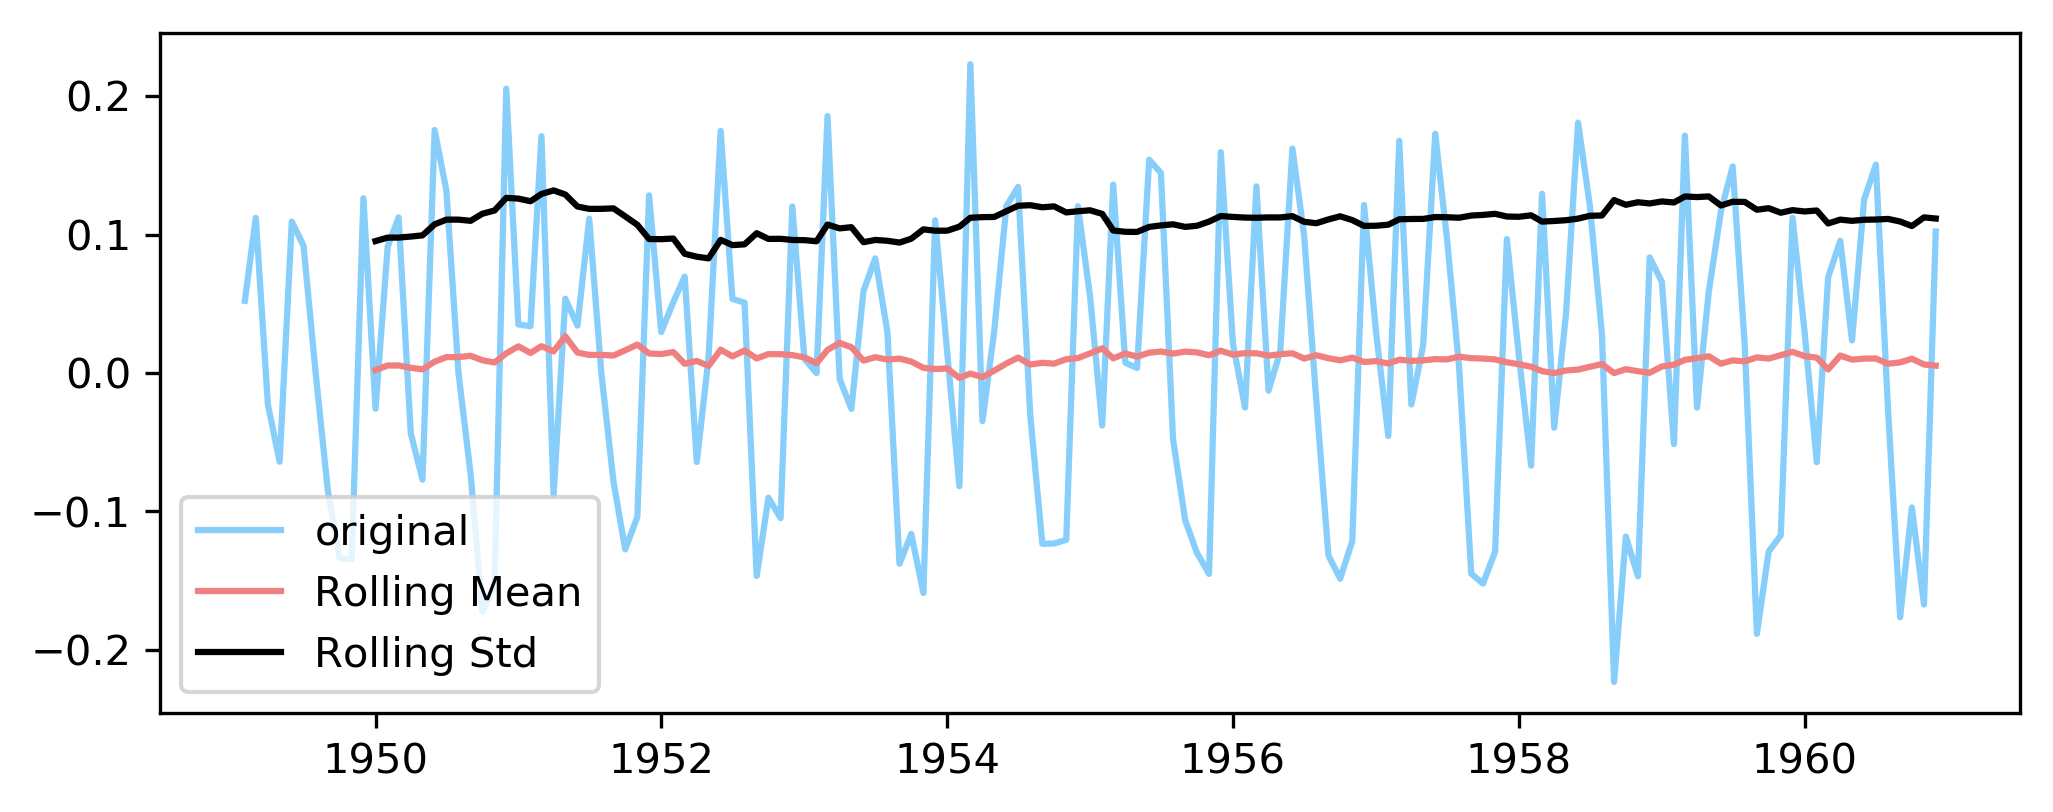

In [21]:
rolling_stats(ts_log_diff)

In [22]:
dickeyfuller(ts_log_diff)

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64

Second order differencing

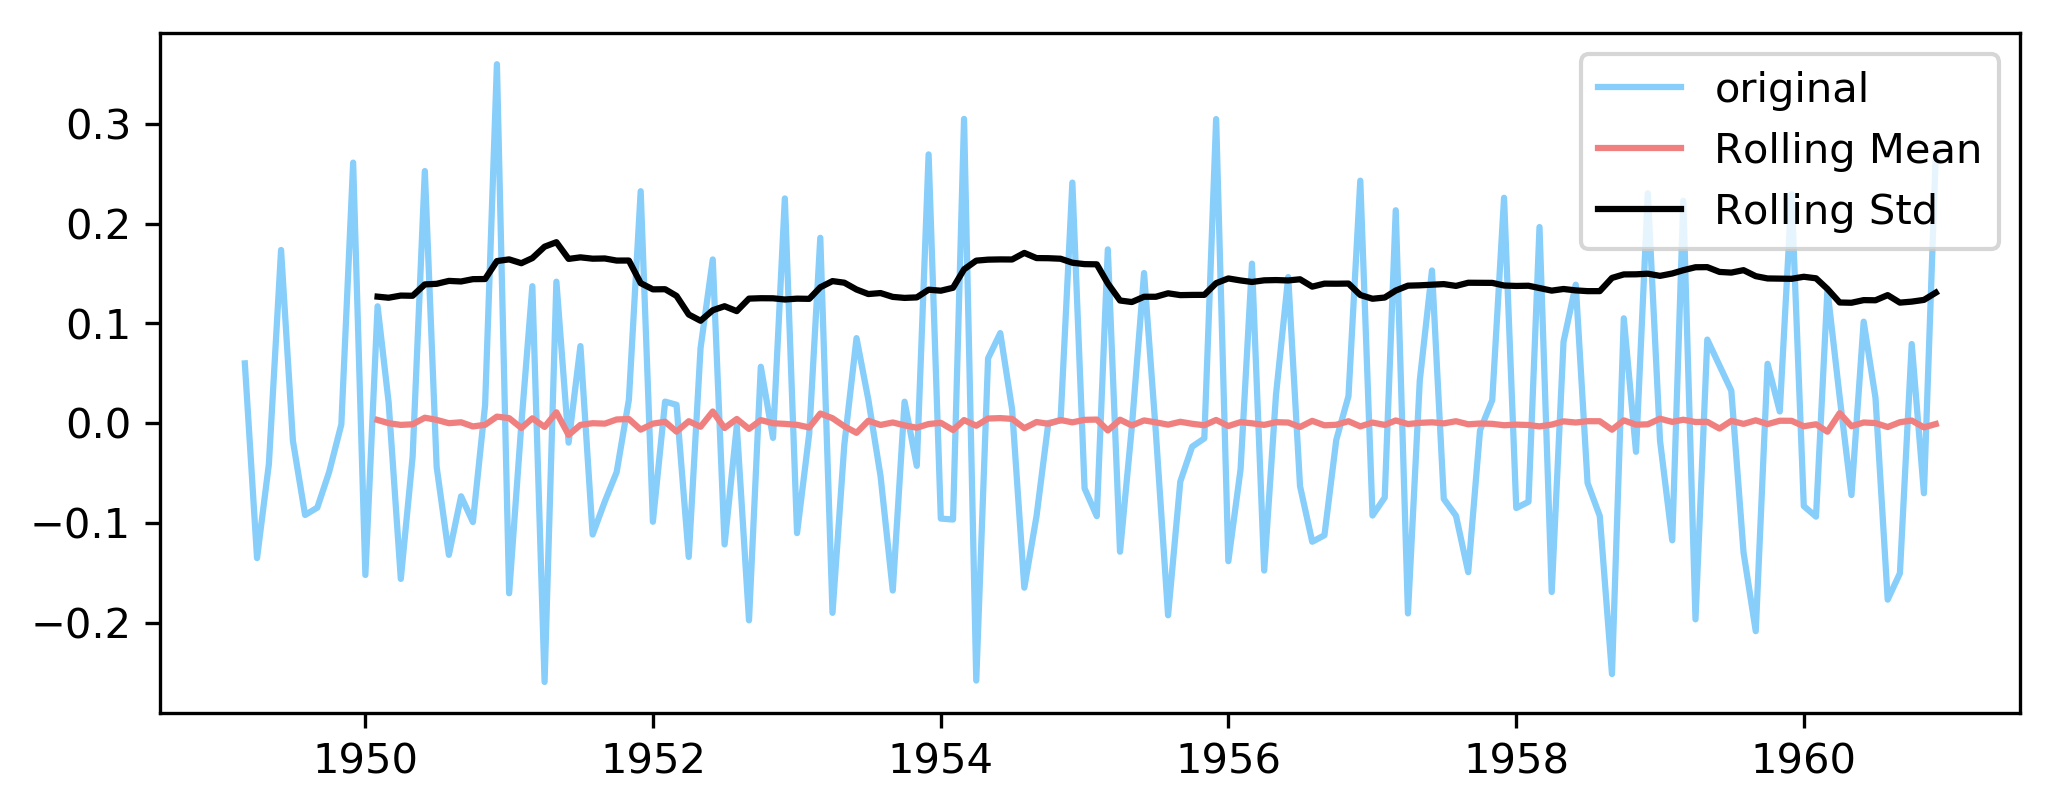

In [23]:
ts_log_diff2 = (ts_log_diff-ts_log_diff.shift()).dropna()
rolling_stats(ts_log_diff2)

In [24]:
dickeyfuller(ts_log_diff2)

Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64

#### Decomposing

In [25]:
decomposition = seasonal_decompose(ts_log)

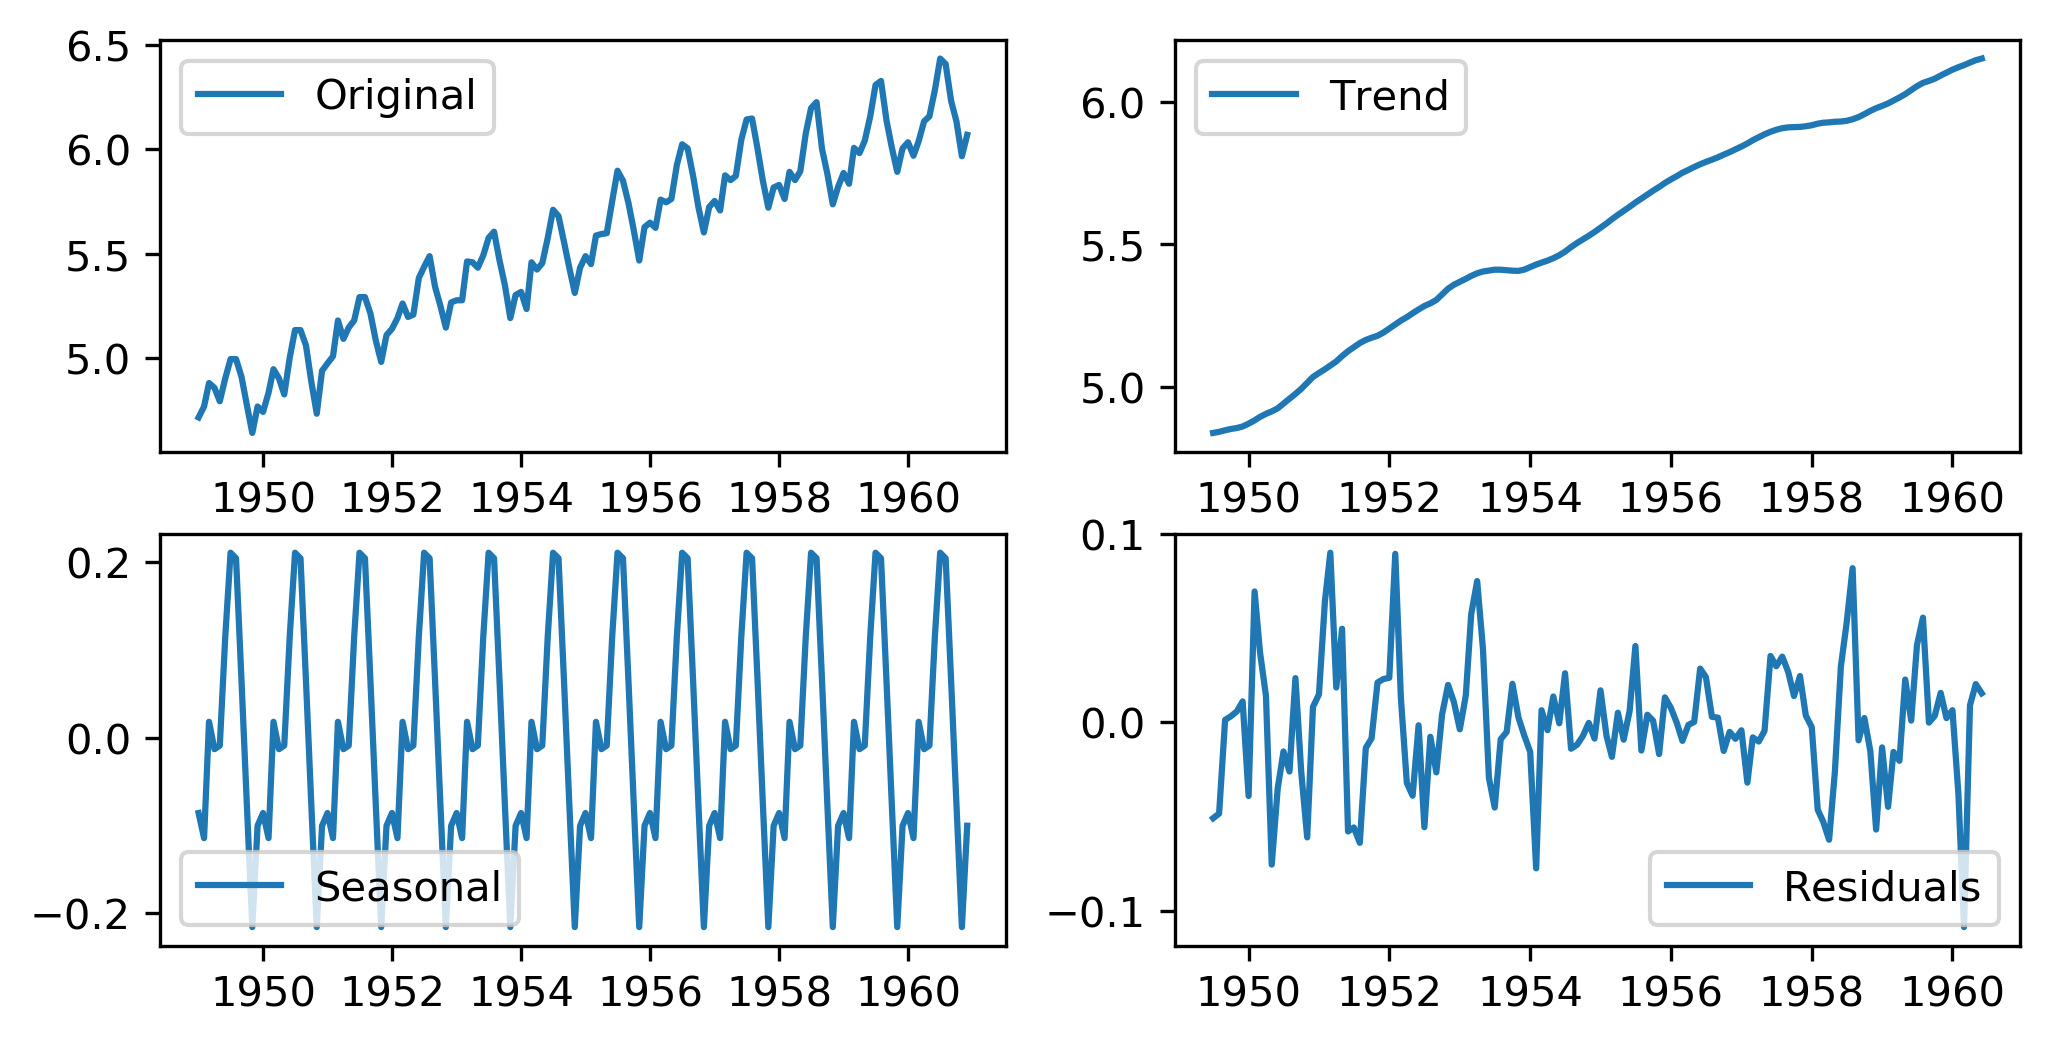

In [26]:
fig, axes = plt.subplots(2, 2, figsize = (8, 4))
axes[0][0].plot(ts_log, label = 'Original')
axes[0][1].plot(decomposition.trend, label='Trend')
axes[1][0].plot(decomposition.seasonal, label='Seasonal')
axes[1][1].plot(decomposition.resid, label='Residuals')
for ax in fig.axes:
    ax.legend();

Check the stationarity of the residuals

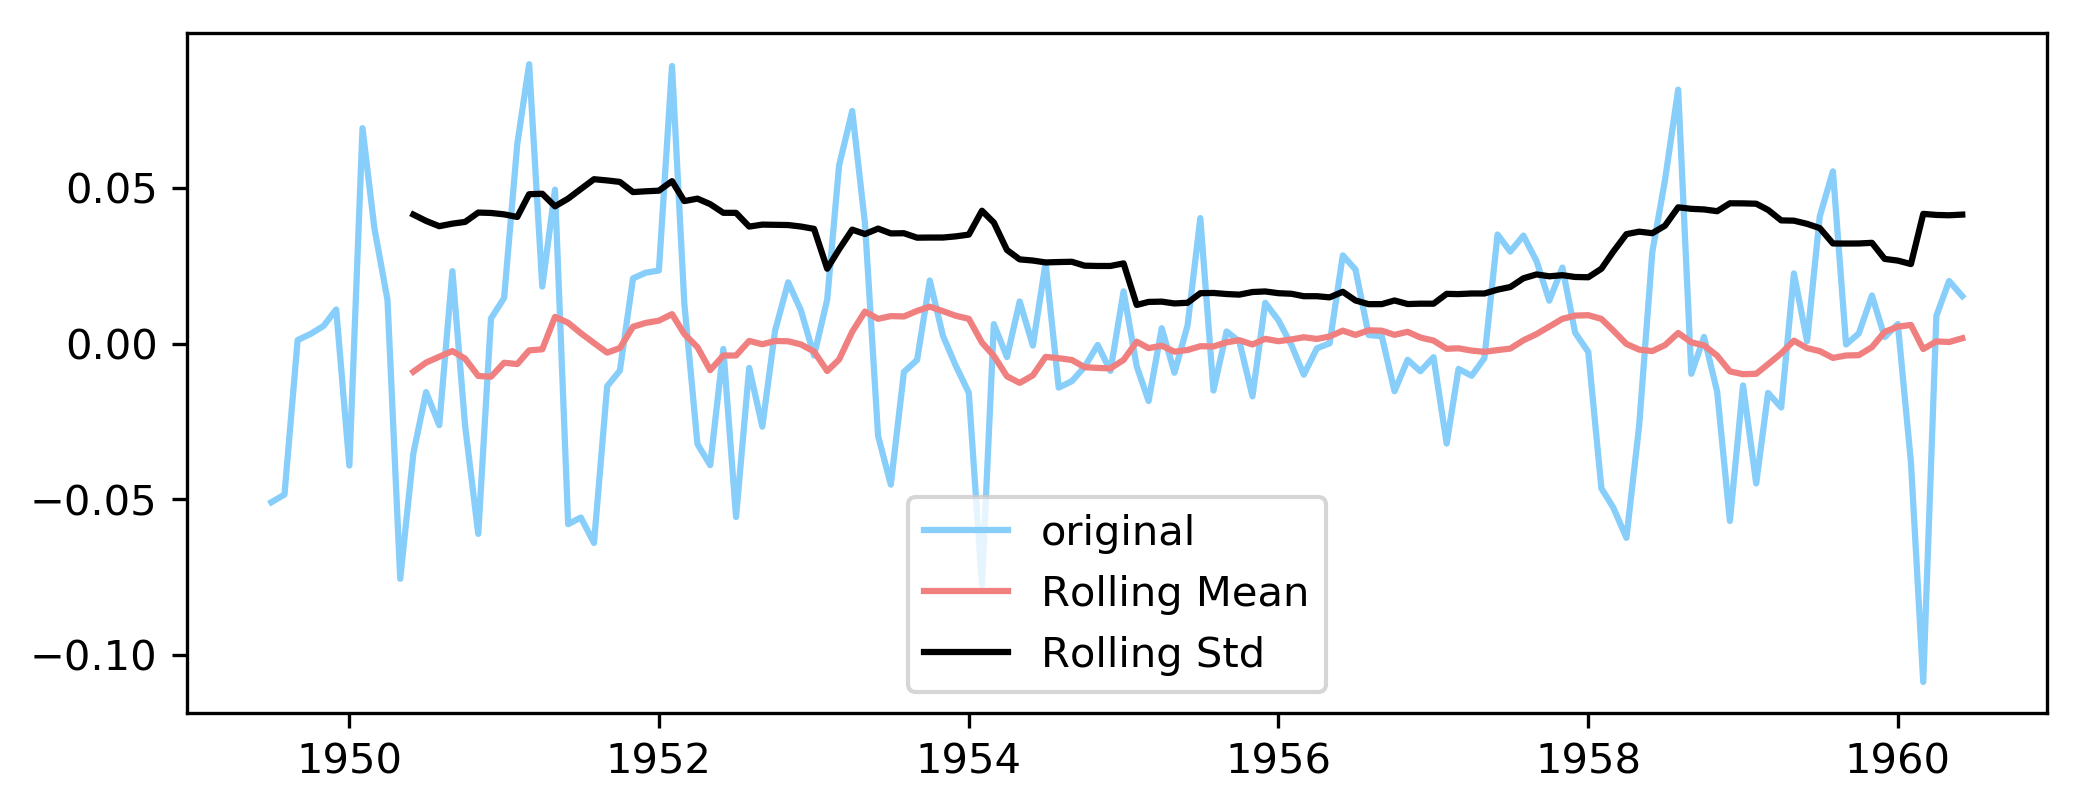

In [27]:
ts_log_decompse = decomposition.resid.dropna()
rolling_stats(ts_log_decompse)

In [28]:
dickeyfuller(ts_log_decompse)

Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64

## Forecasting a Time Series with ARIMA

In [29]:
lag_acf = acf(ts_log_diff, nlags = 20)
lag_pacf = pacf(ts_log_diff, nlags = 20, method = 'ols')

The confidence interval is approximately $Z/\sqrt{N}$, where Z is the Z score for the confidence percentage, and N is the sample size.

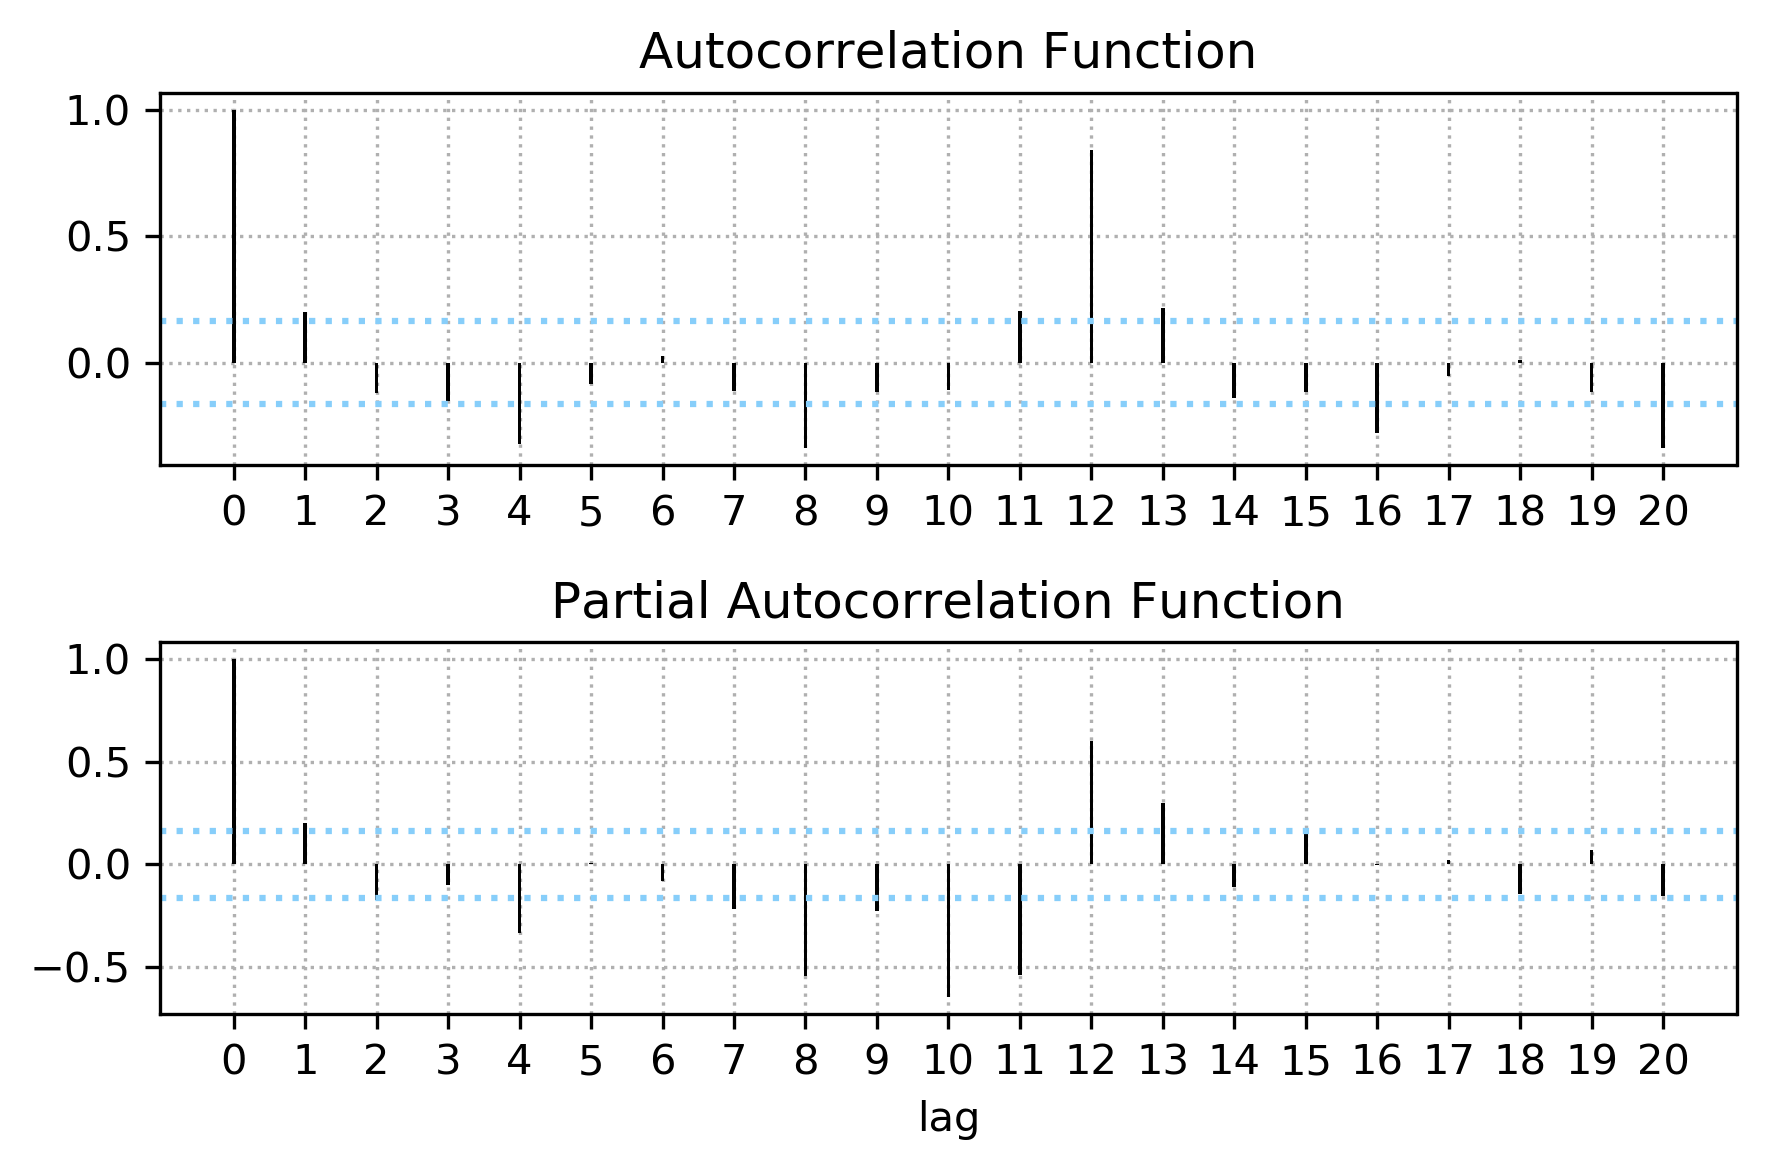

In [30]:
fig, axes = plt.subplots(2, 1, figsize = (6, 4))
width = 0.05
axes[0].bar(range(len(lag_acf)), lag_acf, width = width, color = 'k', zorder = 2)
axes[1].bar(range(len(lag_pacf)), lag_pacf, width = width, color = 'k', zorder = 2)
axes[0].set_title('Autocorrelation Function')
axes[1].set_title('Partial Autocorrelation Function')
axes[1].set_xlabel('lag')
for ax in axes:
    ax.grid(ls=':')
    ax.axhline(1.96/np.sqrt(len(ts_log_diff)), ls = ':', color = 'lightskyblue')
    ax.axhline(-1.96/np.sqrt(len(ts_log_diff)), ls = ':', color = 'lightskyblue')
    ax.set_xticks(range(21))
plt.tight_layout()

From these plots, we can determine p and q for ARIMA:

1. p=2, since PACF first hit confidence interval at lag 2
1. q=2, since ACF first hit confidence interval at lag 2
1. d=1, as shown in previous section that first order differencing is good

We gonna test 3 different ARIMA models considering individuals as well as combined effects.

Pandas has autocorrelation_plot that does similar things.

(0, 20)

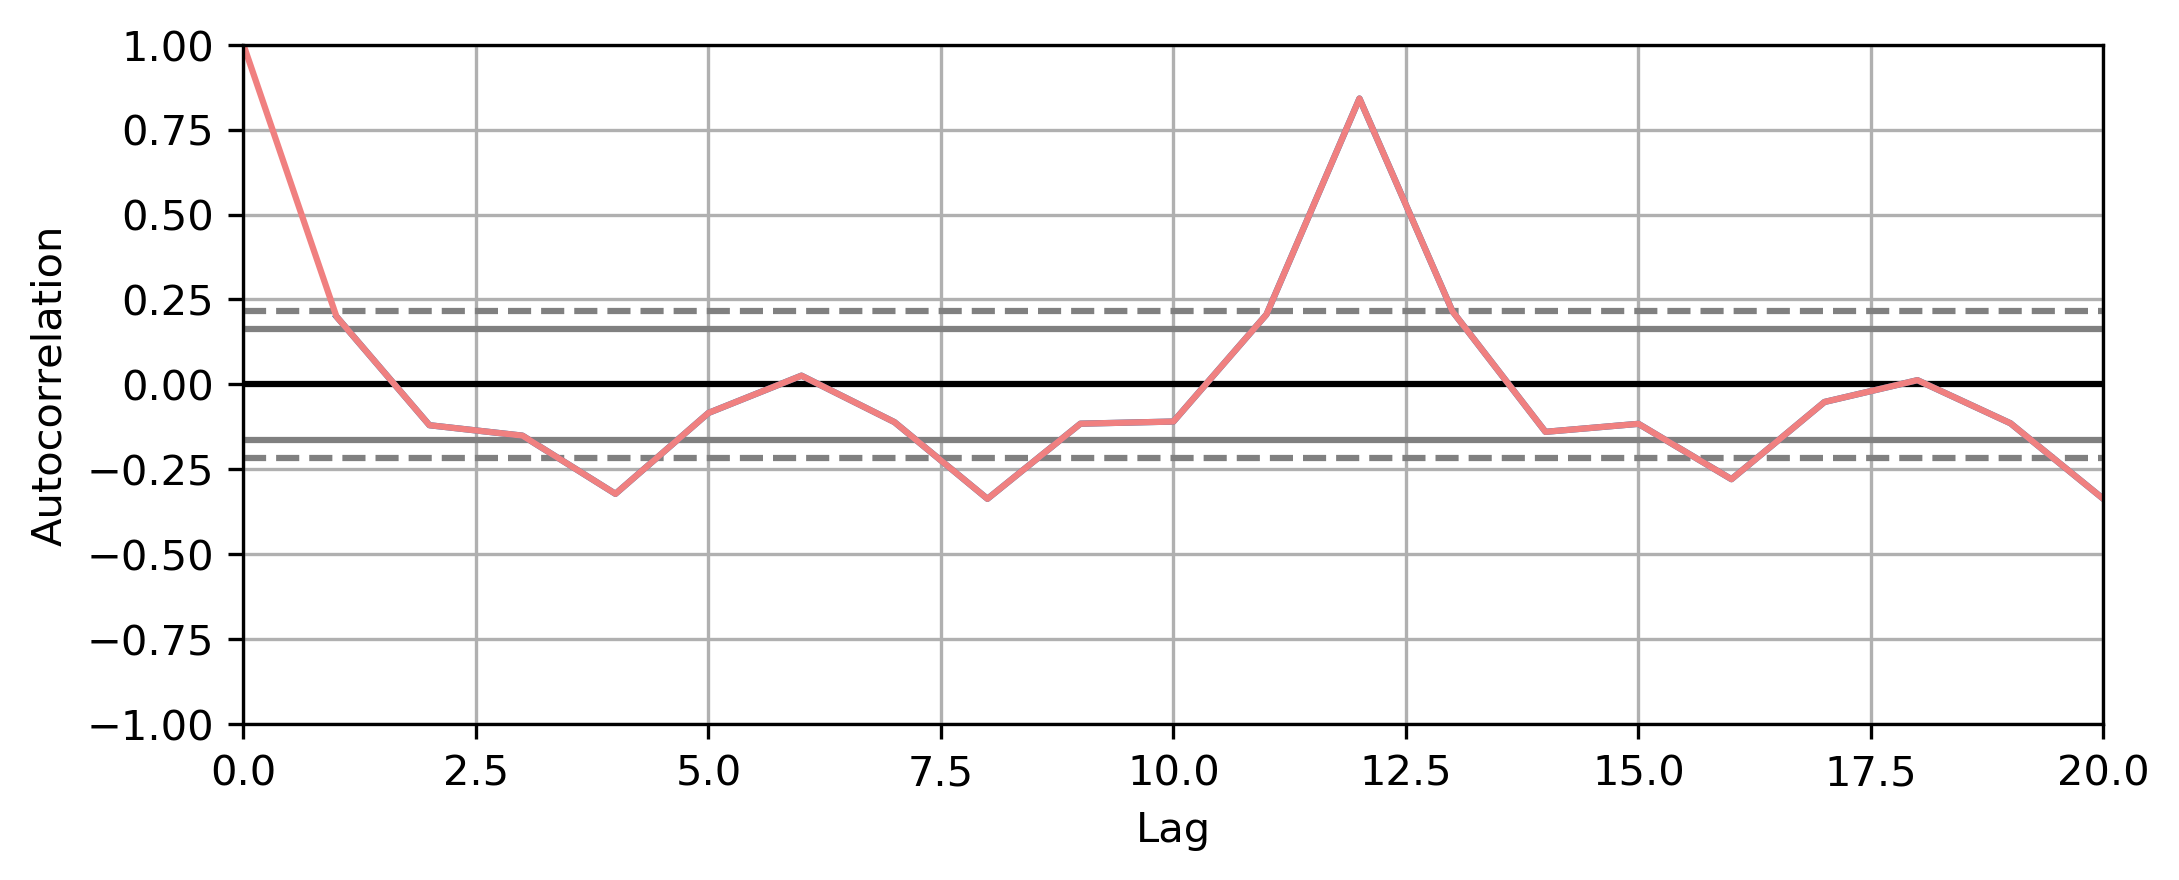

In [31]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(ts_log_diff)
plt.plot(lag_acf, color = 'lightcoral')
plt.xlim((0,20))

### AR model

In [32]:
ar = ARIMA(ts_log, order=(2, 1, 0))
ar_results = ar.fit(disp = 0)

/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


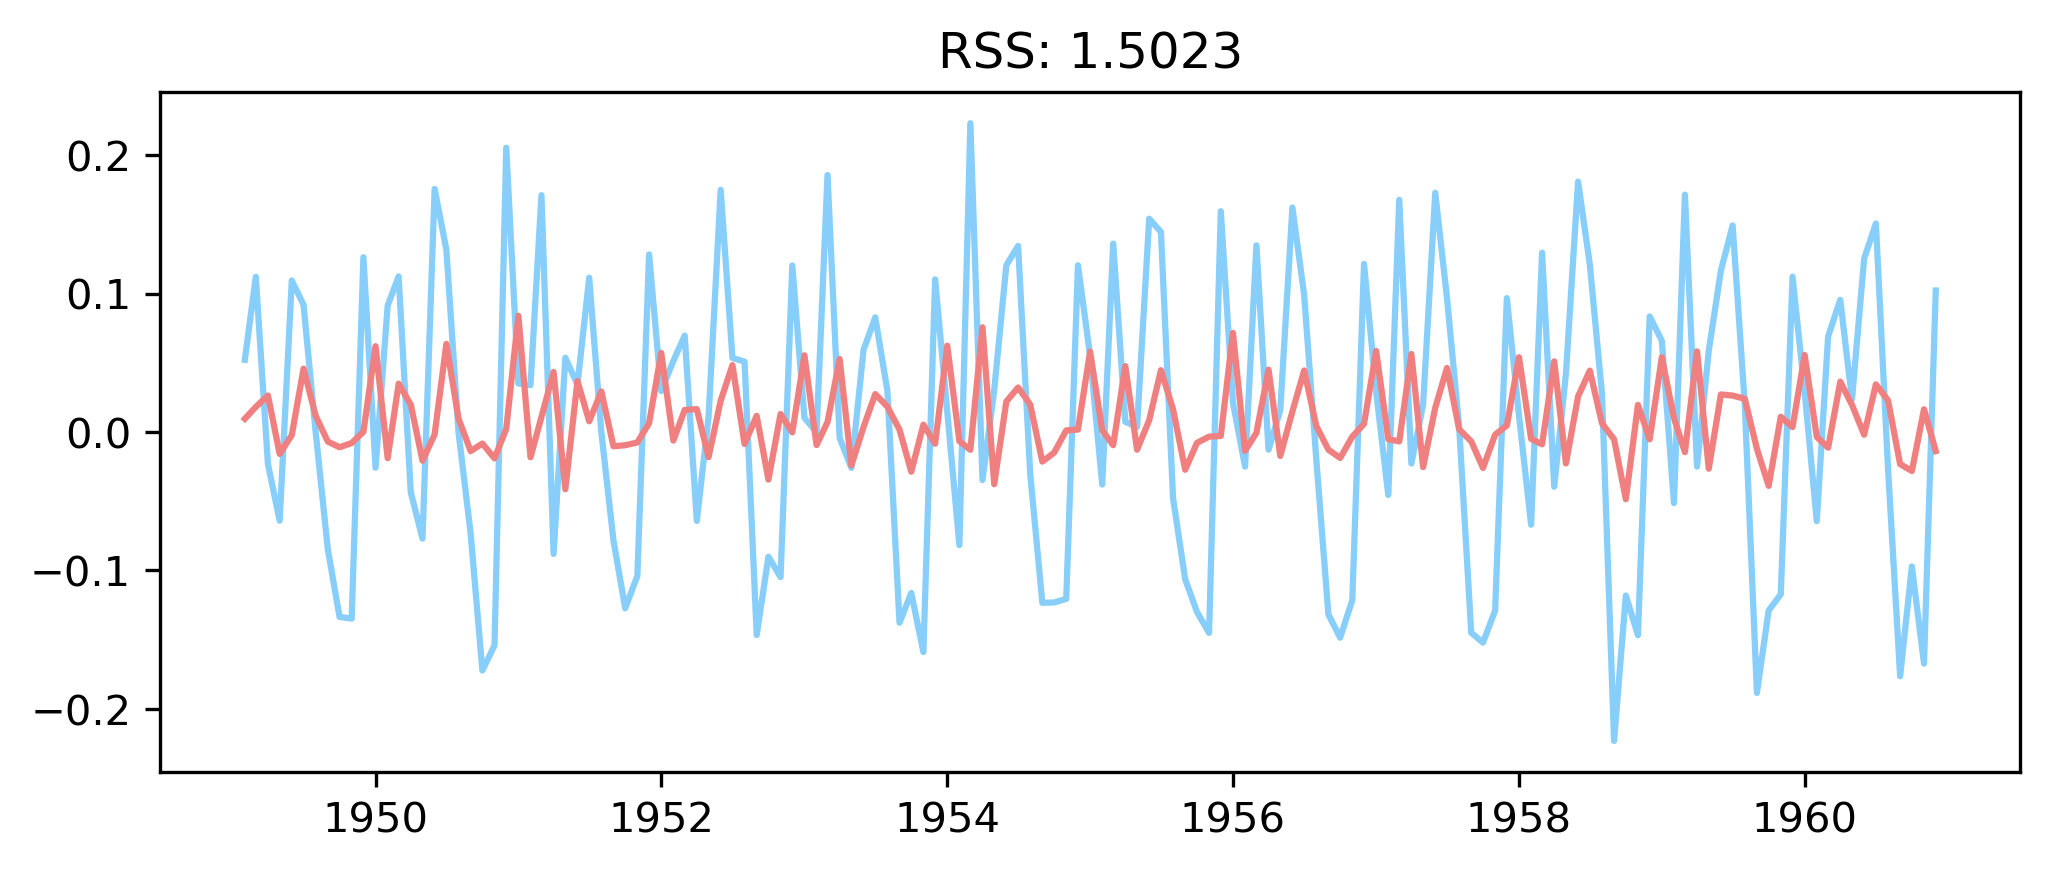

In [33]:
plt.plot(ts_log_diff, c = 'lightskyblue')
plt.plot(ar_results.fittedvalues, c = 'lightcoral')
plt.title('RSS: %.4f'% sum((ar_results.fittedvalues-ts_log_diff)**2));

### MA model

In [34]:
ma = ARIMA(ts_log, order = (0, 1, 2))
ma_results = ma.fit(disp=0)

/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


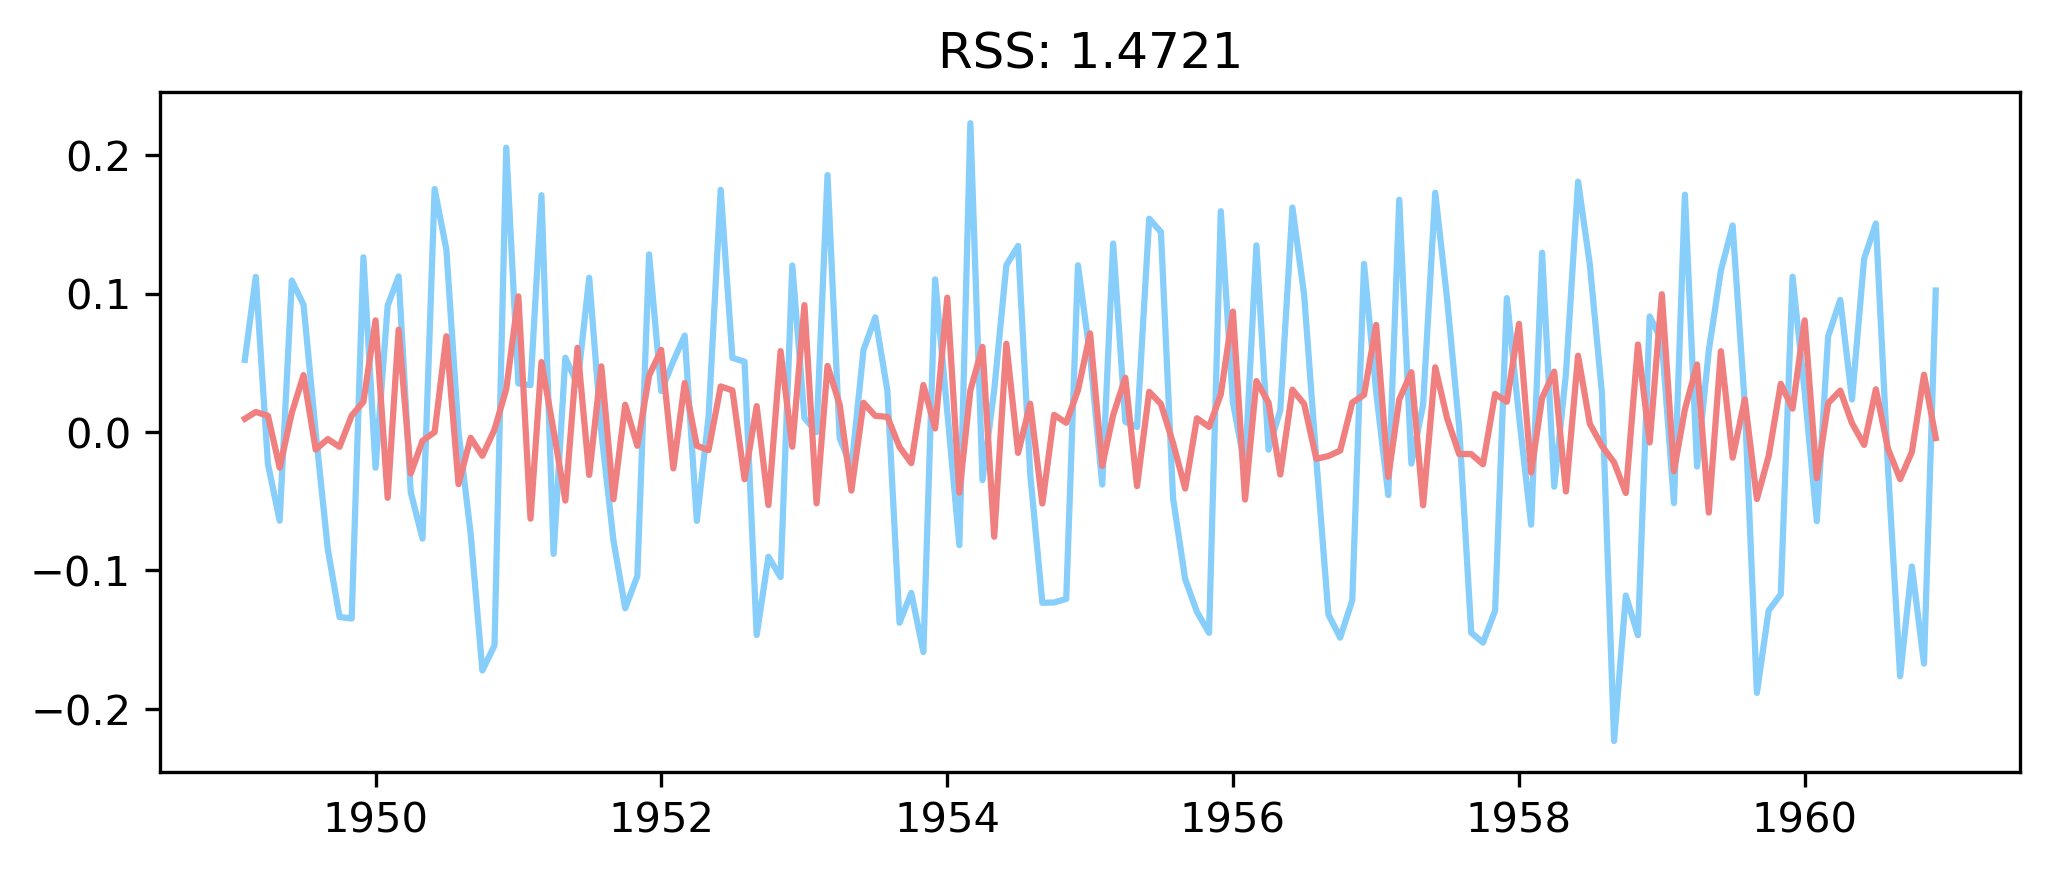

In [35]:
plt.plot(ts_log_diff, c = 'lightskyblue')
plt.plot(ma_results.fittedvalues, c = 'lightcoral')
plt.title('RSS: %.4f'% sum((ma_results.fittedvalues-ts_log_diff)**2));

### Combined Model

/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


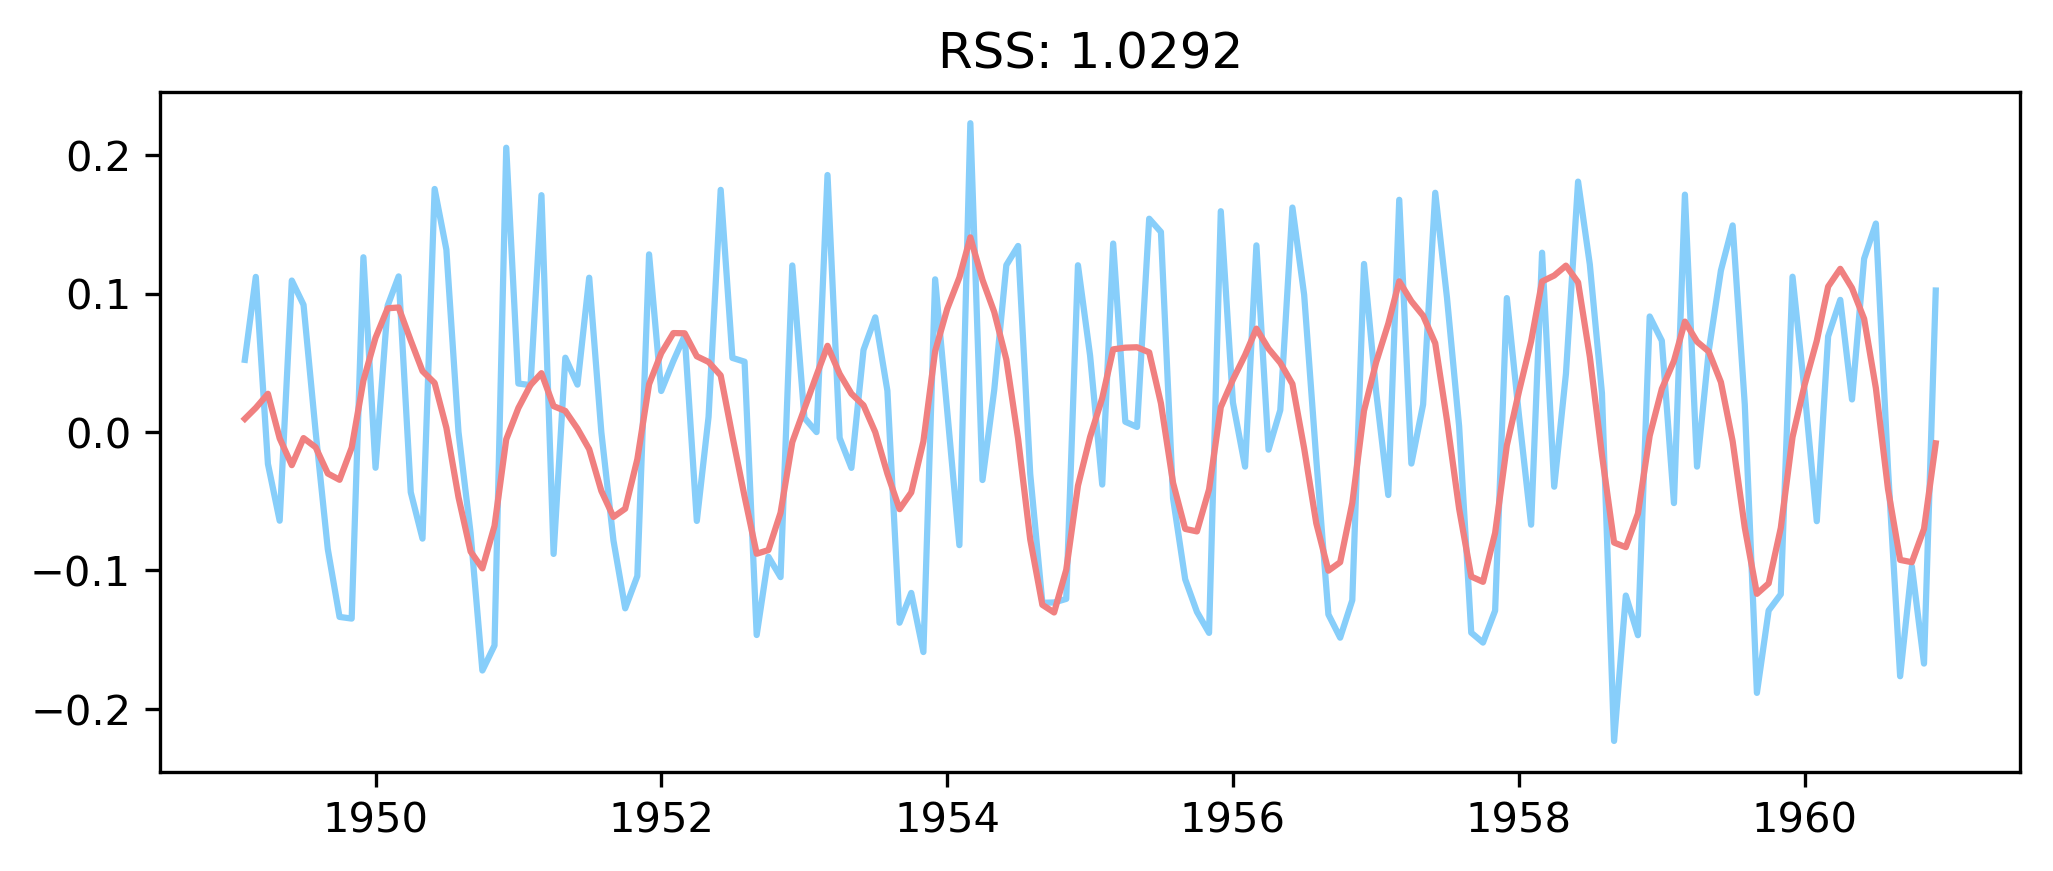

In [36]:
arima = ARIMA(ts_log, order = (2, 1, 2))
arima_results = arima.fit(disp = 0)
plt.plot(ts_log_diff, c='lightskyblue')
plt.plot(arima_results.fittedvalues, color='lightcoral')
plt.title('RSS: %.4f'% sum((arima_results.fittedvalues-ts_log_diff)**2));

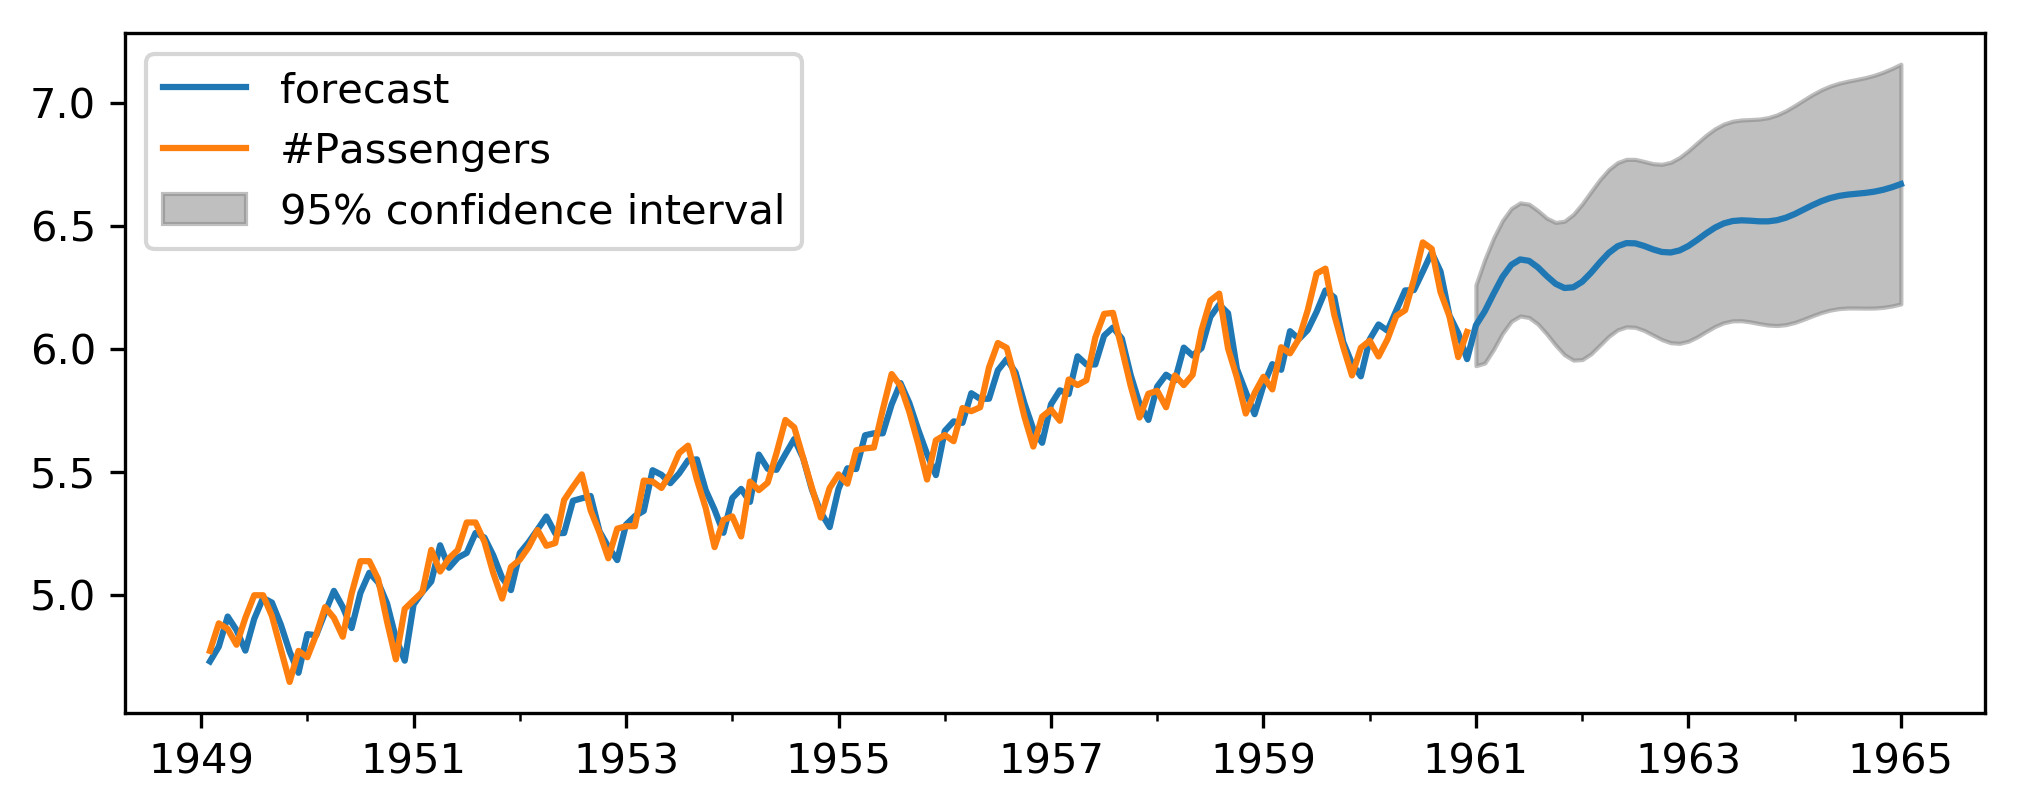

In [37]:
arima_results.plot_predict('1949', '1965');

### Taking it back to original scale

In [38]:
arima_cumsum = arima_results.fittedvalues.cumsum()
arima_log_fitted = pd.Series(ts_log.iloc[0], index=ts_log.index)
arima_log_fitted = arima_log_fitted.add(arima_cumsum, fill_value=0)
arim_fitted = np.exp(arima_log_fitted)

In [39]:
pred_time = pd.date_range(start = ts.index[-1], periods = 25, freq = 'MS')[1:]
pred_vals, _, _ = arima_results.forecast(24)
pred_results = np.exp(pd.Series(pred_vals, index = pred_time))

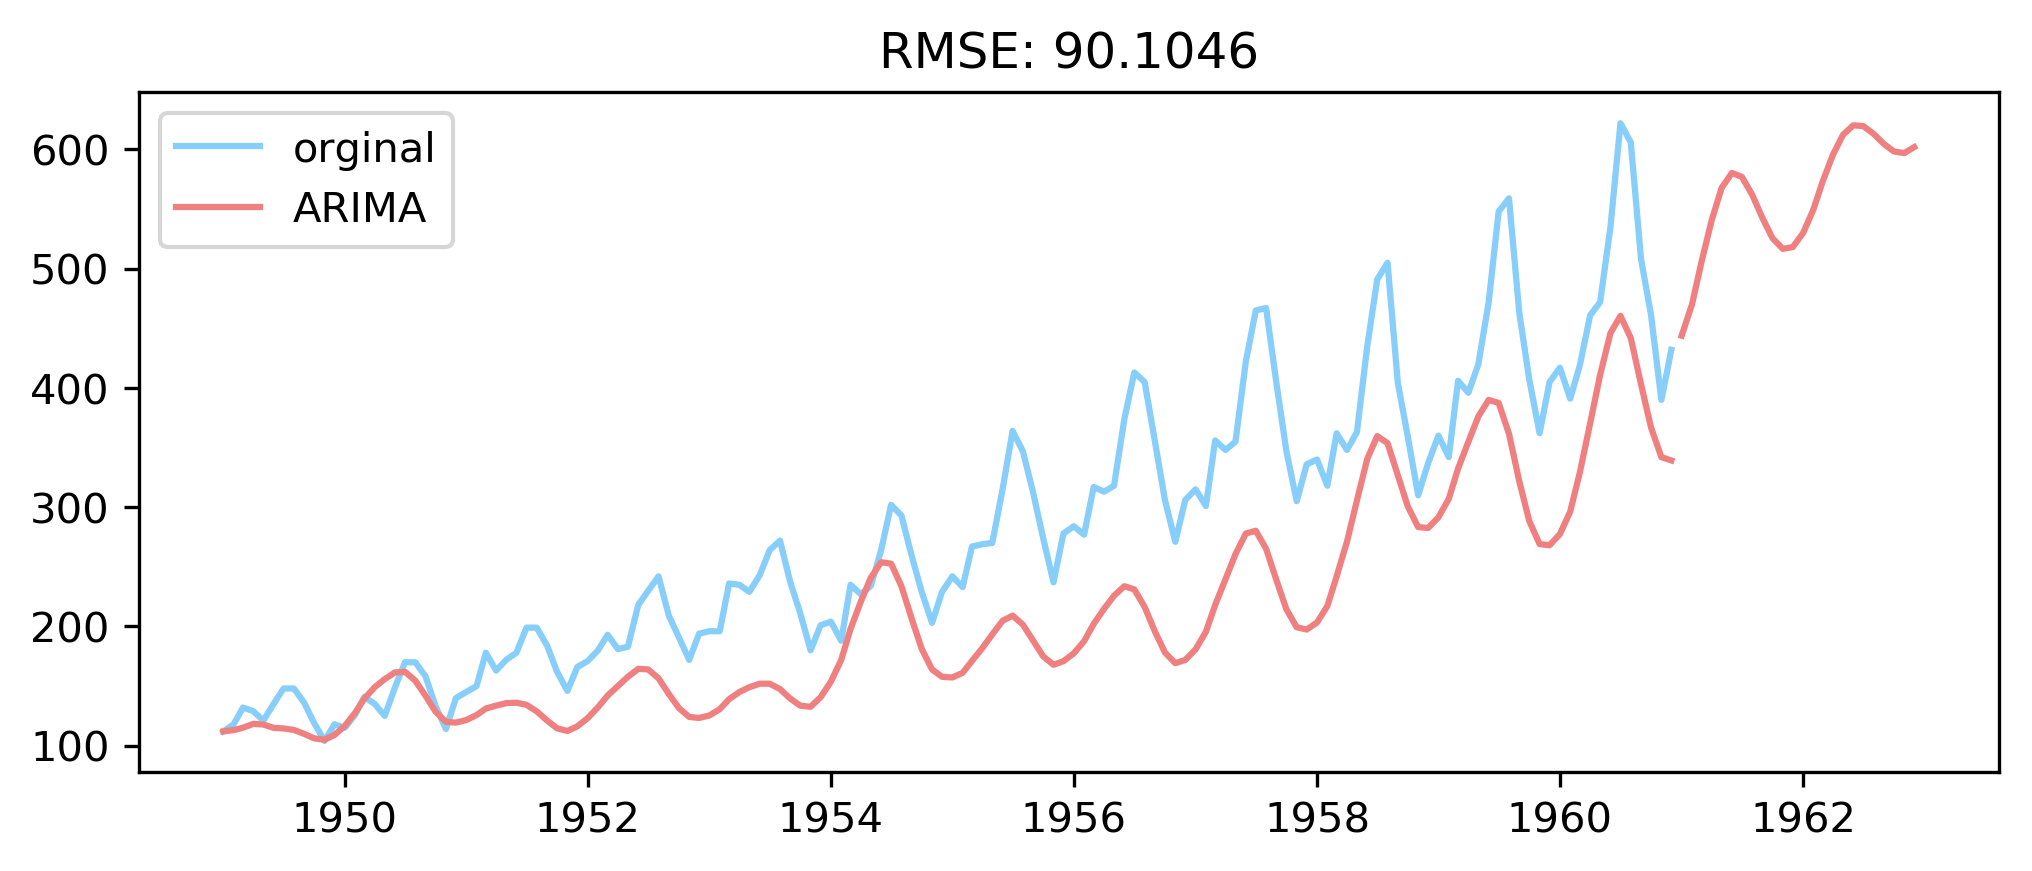

In [40]:
plt.plot(ts, c='lightskyblue', label = 'orginal')
plt.plot(arim_fitted, c='lightcoral')
plt.plot(pred_results, c='lightcoral', label = 'ARIMA')
plt.title('RMSE: %.4f'% np.sqrt(sum((arim_fitted-ts)**2)/len(ts)))
plt.legend();

Seems like the forecast is based on observation values, instead of fitted values.

## ARIMA with seasonal differencing

In the ACF and PACF, we saw a high peak at 12, indicating there's seasonality with period of 12 months. We will perform a seasonal differencing first then fit with ARIMA.

In [41]:
ts_log_diff_sdiff = (ts_log_diff-ts_log_diff.shift(12)).dropna()
sdiff_acf = acf(ts_log_diff_sdiff, nlags = 20)
sdiff_pacf = pacf(ts_log_diff_sdiff, nlags = 20)

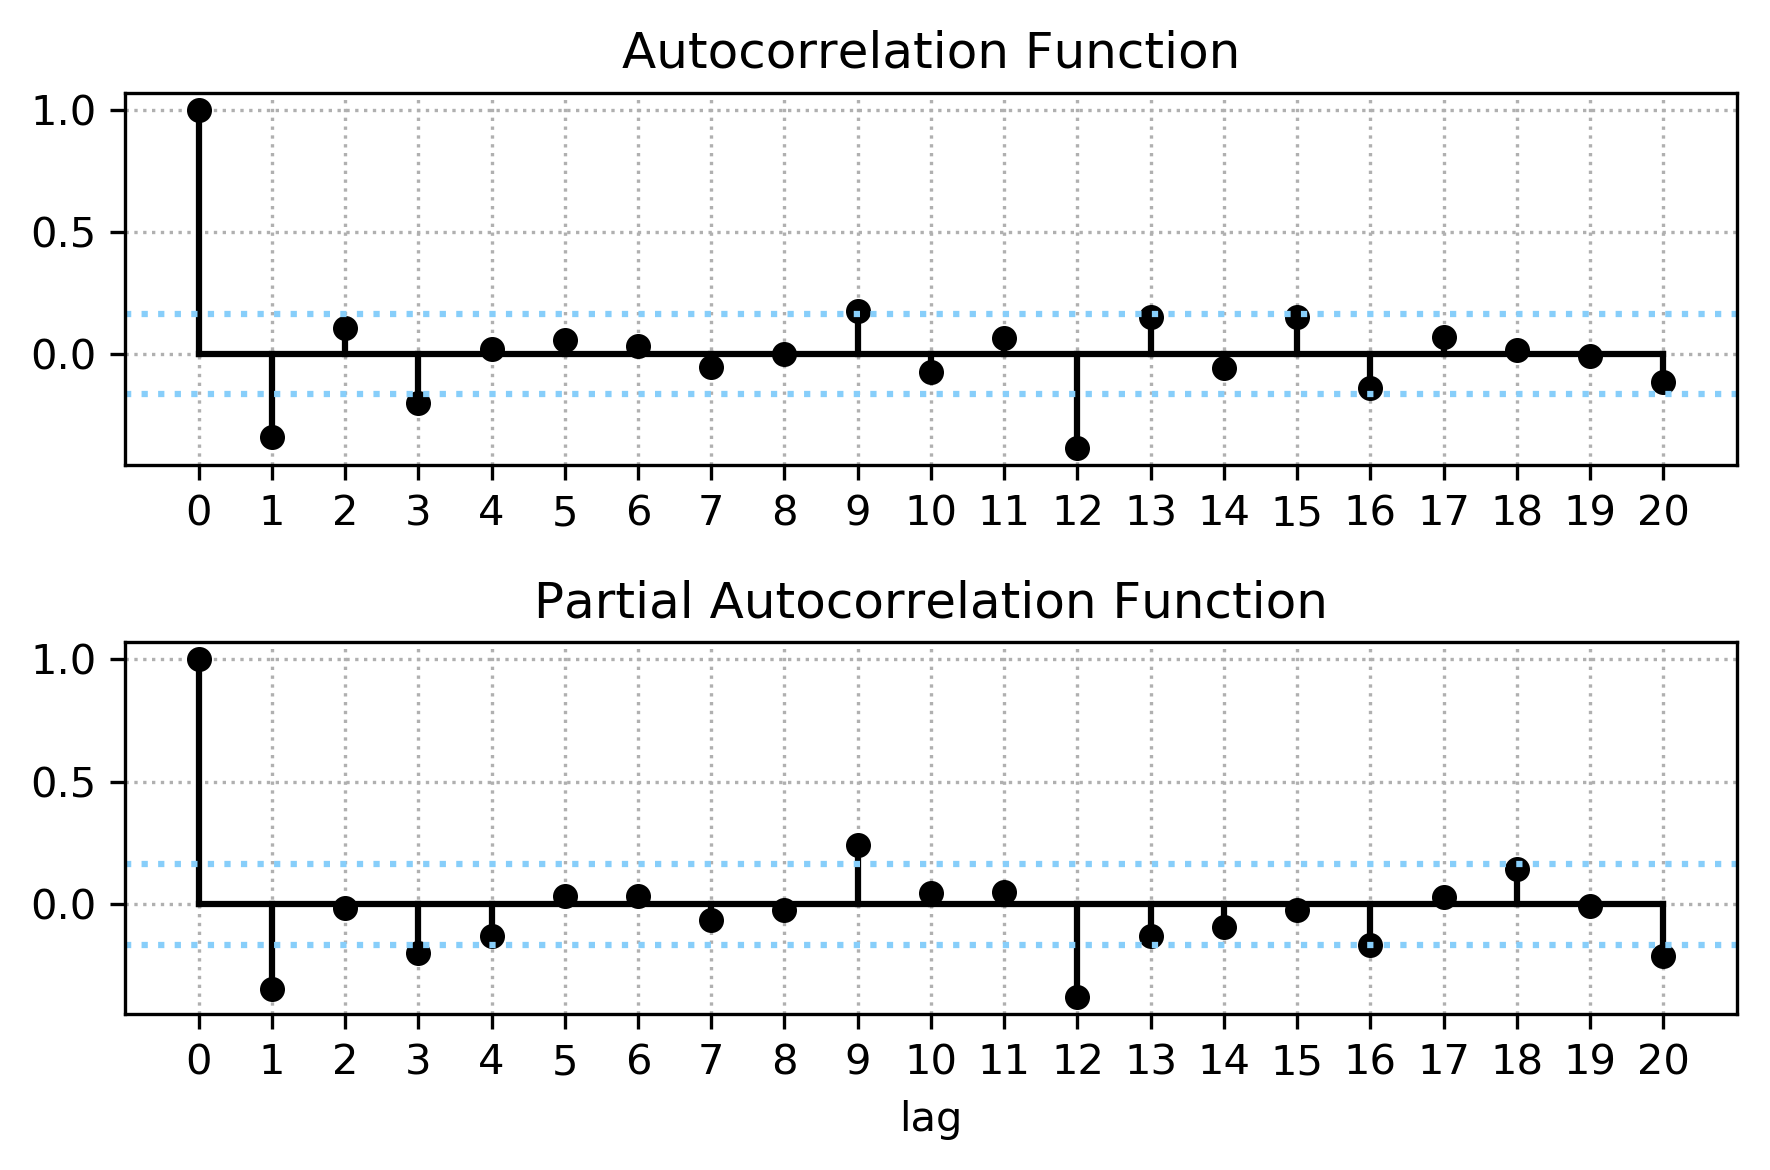

In [42]:
fig, axes = plt.subplots(2, 1, figsize = (6, 4))
markerline, stemlines, baseline = axes[0].stem(range(len(sdiff_acf)), sdiff_acf)
plt.setp(markerline, color = 'k', markersize = 5)
plt.setp(stemlines, color = 'k')
plt.setp(baseline, color = 'k')
markerline, stemlines, baseline = axes[1].stem(range(len(sdiff_pacf)), sdiff_pacf)
plt.setp(markerline, color = 'k', markersize = 5)
plt.setp(stemlines, color = 'k')
plt.setp(baseline, color = 'k')
axes[0].set_title('Autocorrelation Function')
axes[1].set_title('Partial Autocorrelation Function')
axes[1].set_xlabel('lag')
for ax in axes:
    ax.grid(ls=':')
    ax.axhline(1.96/np.sqrt(len(ts_log_diff)), ls = ':', color = 'lightskyblue')
    ax.axhline(-1.96/np.sqrt(len(ts_log_diff)), ls = ':', color = 'lightskyblue')
    ax.set_xticks(range(21))
plt.tight_layout()

From the plot, lets try p=1, q=1

In [50]:
model = SARIMAX(ts_log, order=(1, 1, 1), seasonal_order=(1,0,1,12),
                enforce_stationarity=False, enforce_invertibility=False)

/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [51]:
model_fit = model.fit(disp=False)

/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


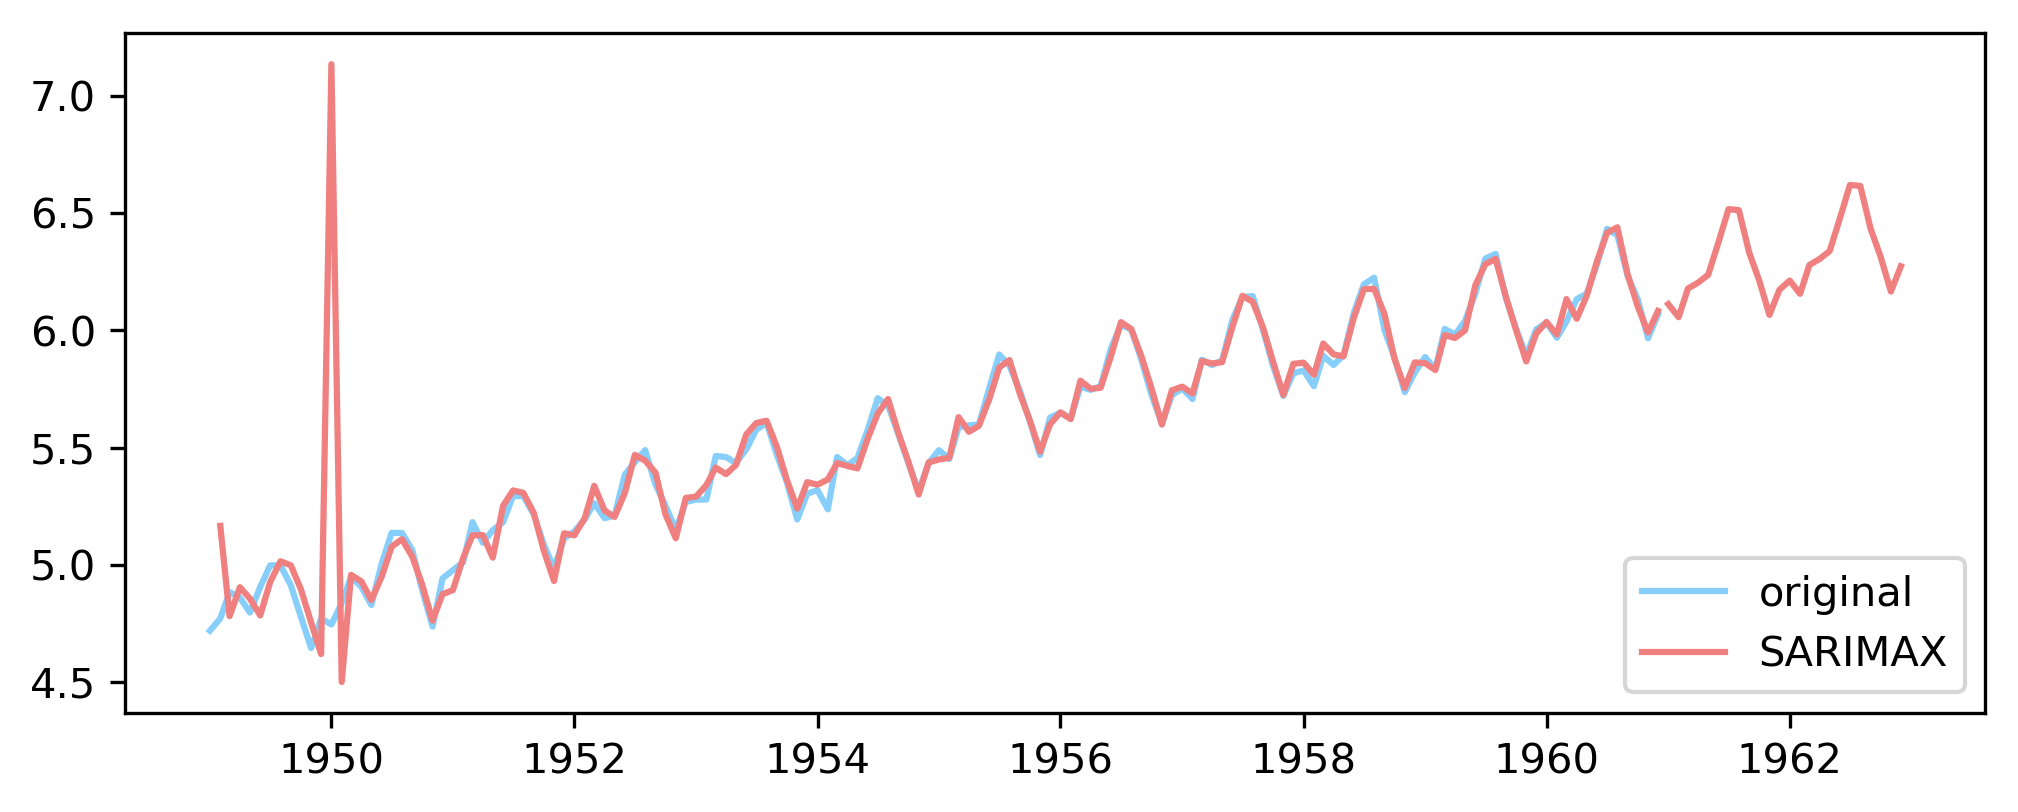

In [52]:
plt.plot(ts_log, c='lightskyblue', label='original')
plt.plot(model_fit.fittedvalues[1:],c='lightcoral', label='SARIMAX')
plt.plot(model_fit.forecast(24), c='lightcoral')
plt.legend();

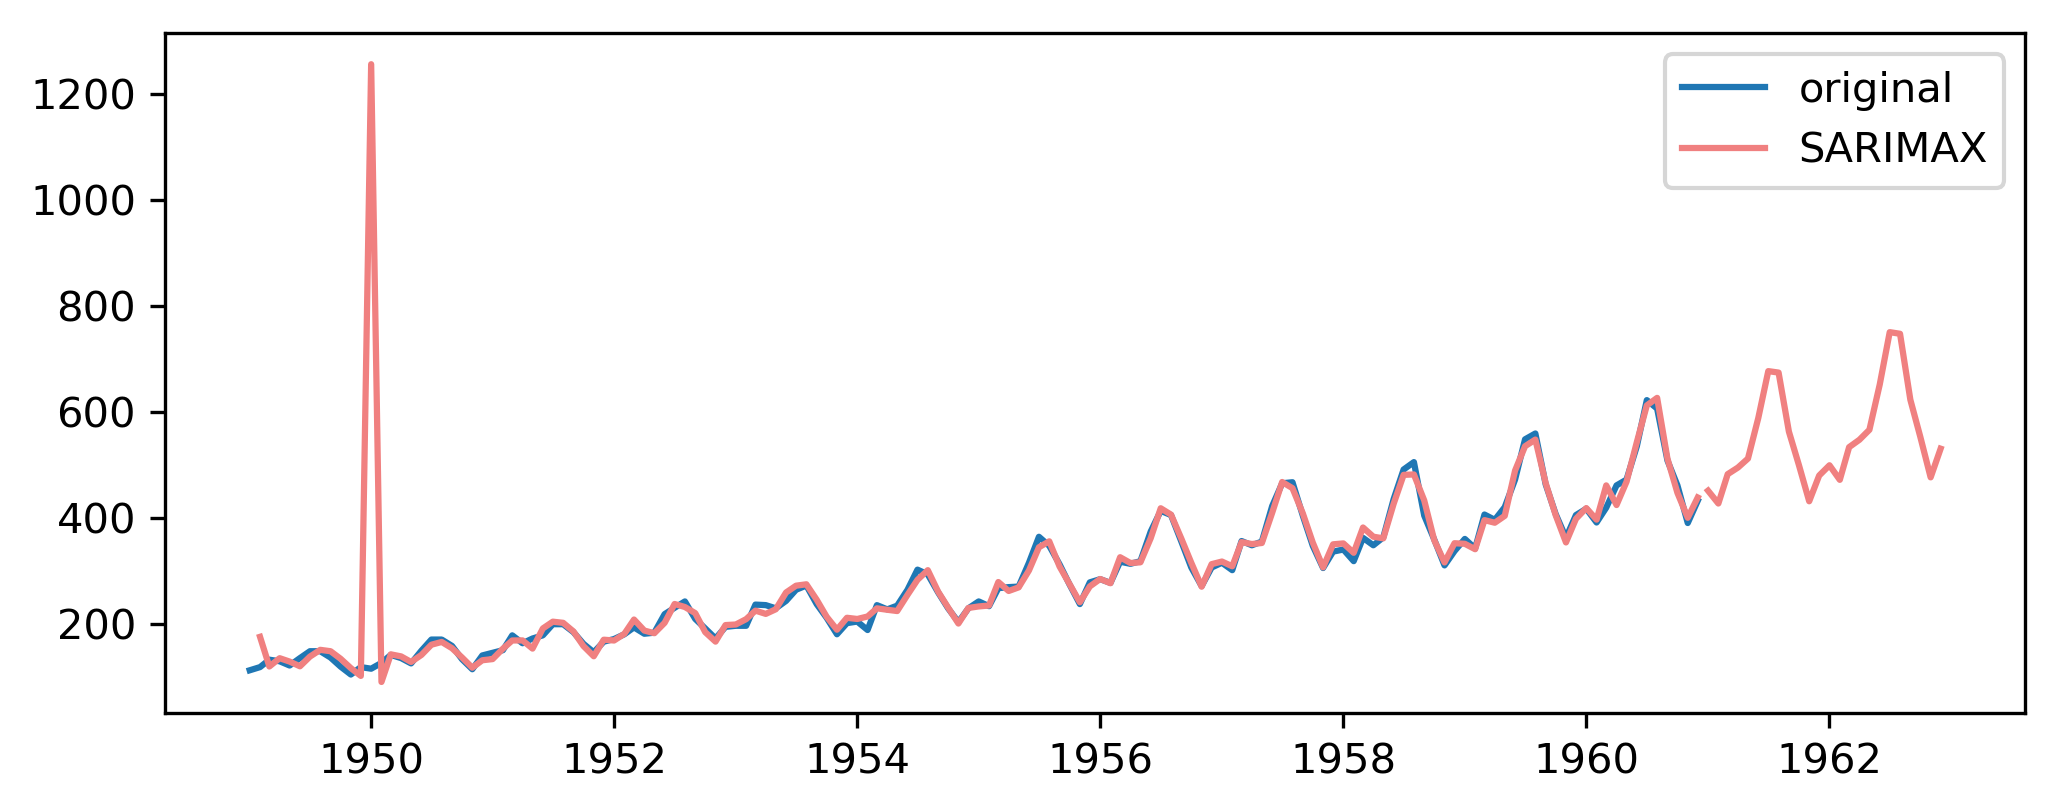

In [53]:
plt.plot(ts, label='original')
plt.plot(np.exp(model_fit.fittedvalues[1:]),c='lightcoral', label='SARIMAX')
plt.plot(np.exp(model_fit.forecast(24)), c='lightcoral')
plt.legend();

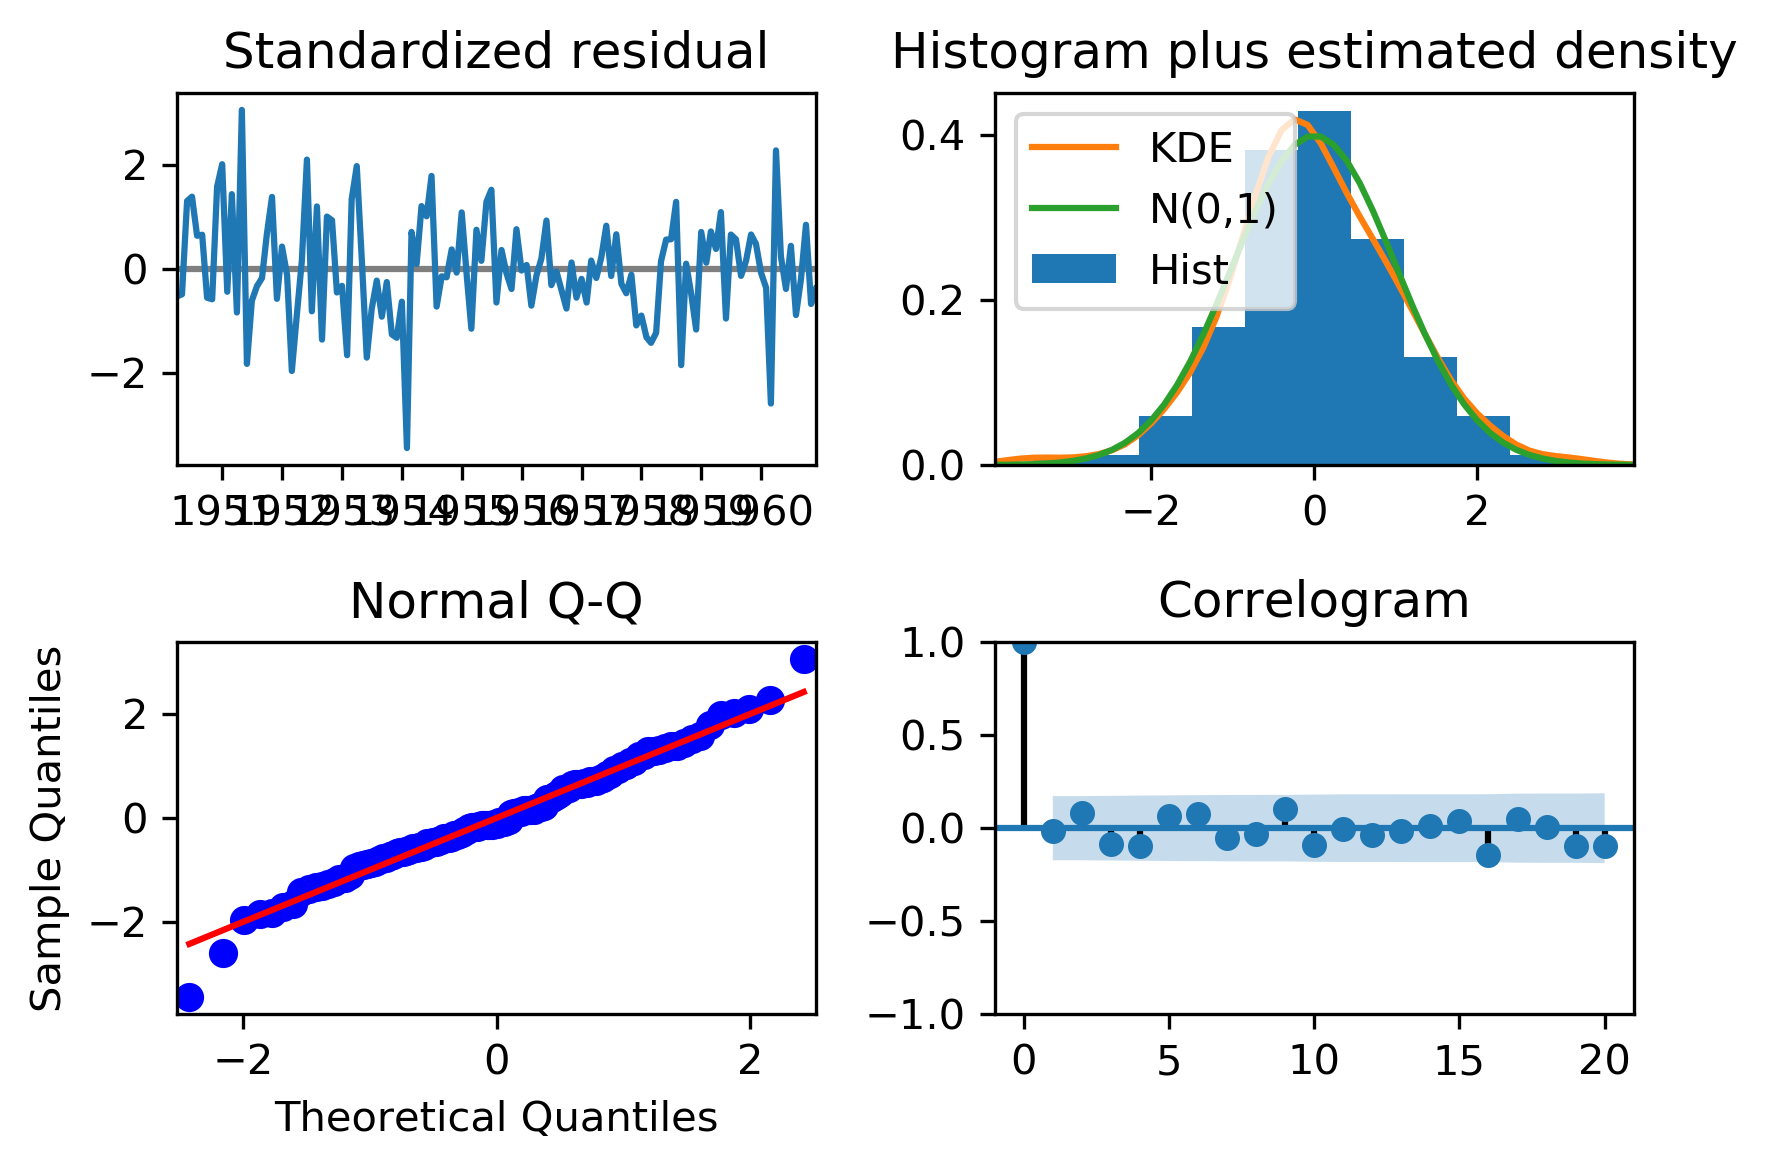

In [54]:
model_fit.plot_diagnostics(lags = 20, figsize=(6, 4))
plt.tight_layout()

### Grid search 

In [55]:
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets

In [56]:
for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            mod = SARIMAX(ts_log, order=param, seasonal_order=seasonal_param,
                          enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, seasonal_param, results.aic))
        except:
            continue

/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:898.7367486840988
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:687.374901731452
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:-150.62577301420401


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:-179.24122978555855
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:-344.53629719317615


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:-342.60891909438055
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:-225.90869150521556


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:-301.46045675079995
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:704.009739506531


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:509.22247300887335
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:-254.3407732232567


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:-248.42231761454315
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:-396.27944658532186


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:-395.7137256045813
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:-271.4312317936334


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:-339.4992838800968
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:-230.0413295835742


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:-296.95709212238455
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:-431.23090994156587


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:-421.5976809299504
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:-437.3905851739362


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:-462.05751015768215
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:-414.65929067287044


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred fr

ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:-413.3367804413636
ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:-234.53795644509847
ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:-295.13911954618743
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:-442.0383113338882


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:-435.44352335758356
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:-450.02432398363135


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:-472.5933408871746


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:-437.1154281710016


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:-428.8696630867352
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:-231.275600868895


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:-297.4212776391948
ARIMA(1, 0, 0)x(0, 1, 0, 12) - AIC:-436.534024499637


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12) - AIC:-424.30030620681356


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:-446.1887351172549


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:-472.00821880808536


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:-414.78267659703266


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC:-416.29338147643705
ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:-234.56931096837081


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:-294.8975243732675
ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:-445.6166135342762


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:-436.944608781145
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:-451.3875306590252


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:-477.6193831296974


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:-436.07844417115496


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:-431.5721823426922
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:-234.2000982626705


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:-296.6593505187146
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:-445.41397113372255


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:-437.5257976188392
ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:-445.92030710117115


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:-474.892002046956


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:-431.3334029225246


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:-429.77765863198107
ARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:-238.09413783099728


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:-299.1791360478852
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:-440.3039006213103


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:-433.7851509595074


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:-444.7369176007252


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:-471.13307487521513
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:-431.47998699016944


/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:-427.03455692852924


ARIMA(1, 0, 1)x(1, 0, 1, 12) has the lowest AIC.

/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


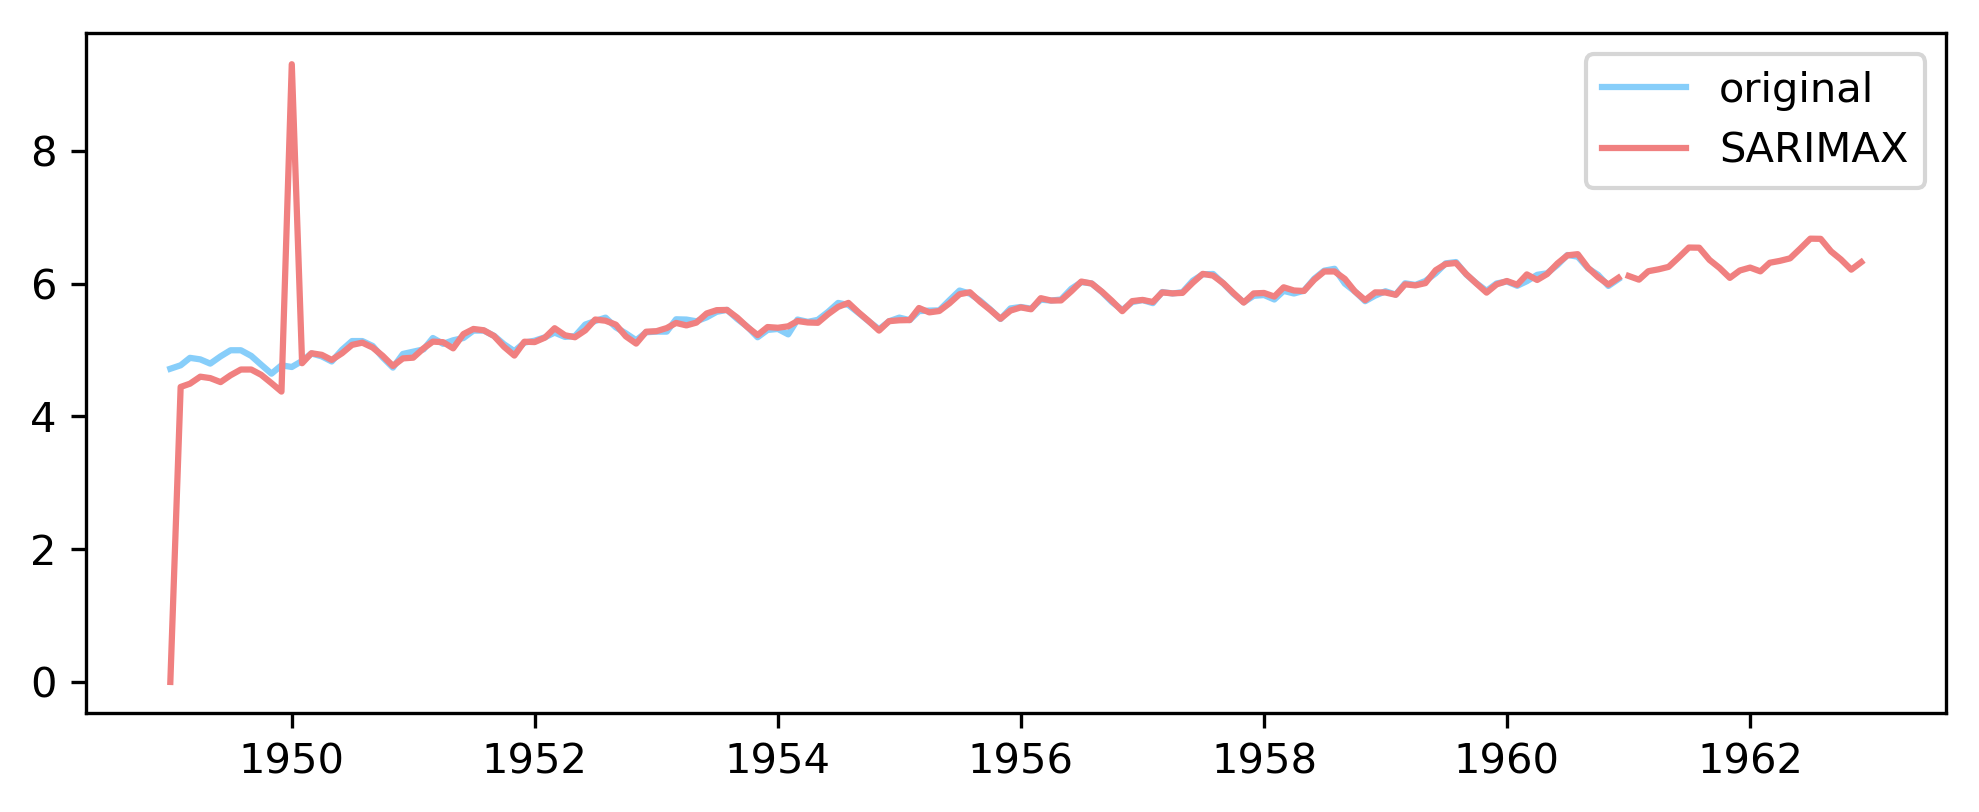

In [57]:
model = SARIMAX(ts_log, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12),
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)
plt.plot(ts_log, c='lightskyblue', label='original')
plt.plot(model_fit.fittedvalues,c='lightcoral', label='SARIMAX')
plt.plot(model_fit.forecast(24), c='lightcoral')
plt.legend();

There's always a weired peak at the beginning of fitted values, but the forecast values seem to be fine.